<center>
    <h1>Fruit Inspection - Second Task: Russet Detection</h1>
    <h2>Image Processing and Computer Vision</h2>
    <h3>Facundo Nicolas Maidana and Riccardo Spolaor</h3>
    <h4>facundo.maidana@studio.unibo.it; riccardo.spolaor@studio.unibo.it</h4>
</center>

---

This notebook presents the development of a system aimed at locating defects and imperfection in fruits. Each fruit is acquired through a NIR *(Near Infra-Red)* and color camera that present little parallax effect among each other.

<table>
    <tr>
        <td><img src="images/second task/C0_000004.png" width="200"/></td>
        <td><img src="images/second task/C1_000004.png" width="200"/></td>
    </tr>
    <tr>
        <td style='text-align:left'>NIR example</td>
        <td style='text-align:left'>Color example</td>
    </tr>
</table>

# 00 Prerequisites
The libraries necessary for the task are imported.

In [1]:
#!pip install sciki

In [2]:
%matplotlib inline

import cv2
import math
import matplotlib.pyplot as plt
import numpy as np
import scipy as sc
from sklearn.feature_extraction.image import extract_patches_2d
from time import process_time, time

# Utils libraries
from graphics import *
from utils import *

The cell below illustrates the version of `OpenCV` used for the task.

In [3]:
print(f'Using OpenCV version: {cv2.__version__}.')

Using OpenCV version: 4.6.0.


The random seed is set for both the `numpy` and `OpenCV` libraries in order to guarantee reproducibility of results.

In [4]:
SEED = 42

cv2.setRNGSeed(SEED)
np.random.seed(SEED)

# 01 Image analysis 
The series of images is firstly imported and plotted.

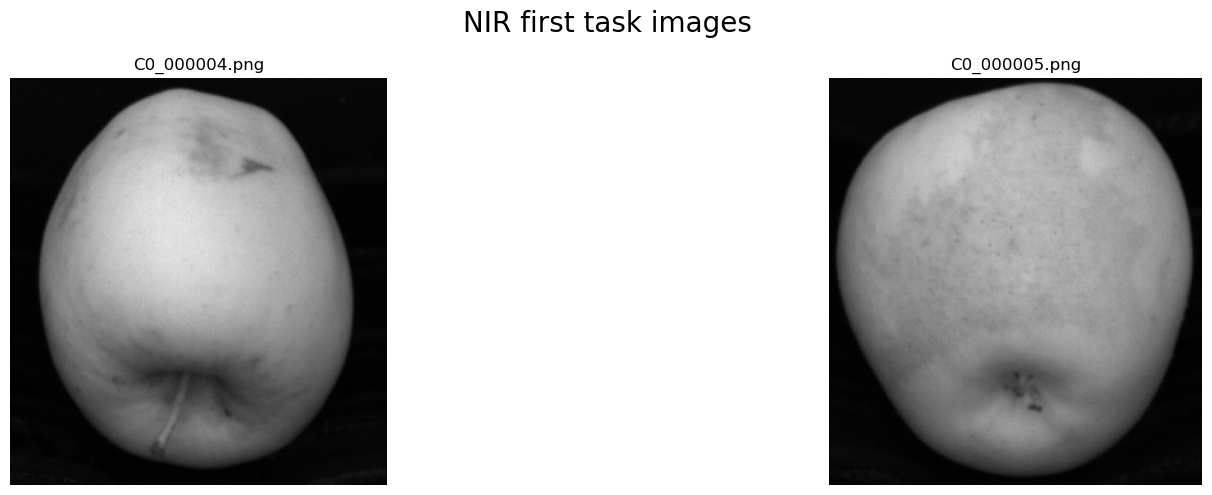

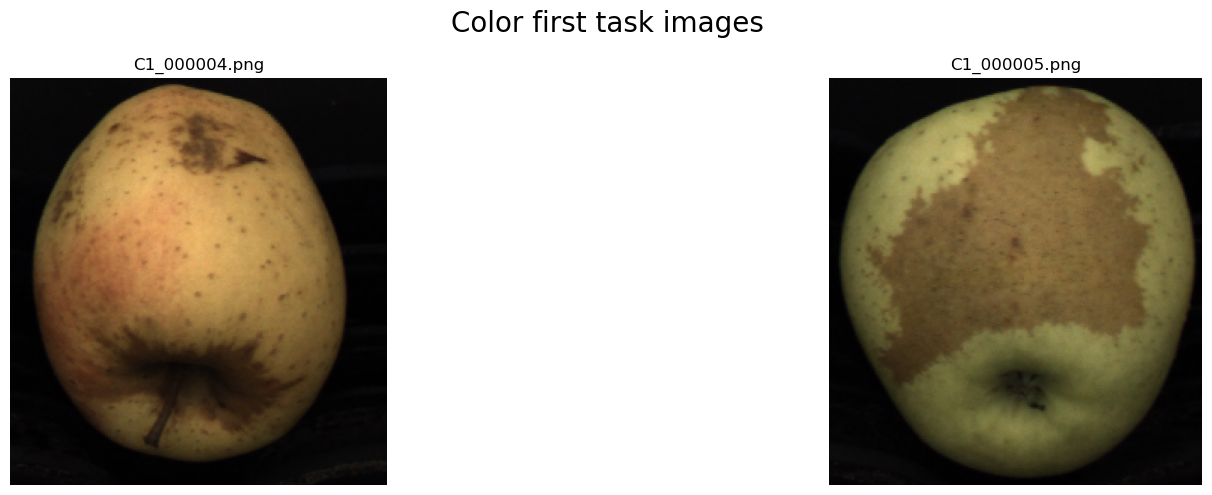

In [5]:
# Create two arrays containing the names of the NIR and color images respectively
nir_names, colour_names = [[f'C{j}_00000{i}.png' for i in [4, 5]] for j in [0,1]]

# Directory where the images are saved
DIR = 'images/second task/'

# Import NIR and colour images
nir_imgs = [cv2.imread(f'{DIR}{img}', cv2.IMREAD_GRAYSCALE) for img in nir_names]
colour_imgs = [cv2.imread(f'{DIR}{img}') for img in colour_names]

# Plot the NIR and color images
plot_image_grid(nir_imgs, 'NIR first task images', nir_names)
plot_image_grid(colour_imgs, 'Color first task images', colour_names)

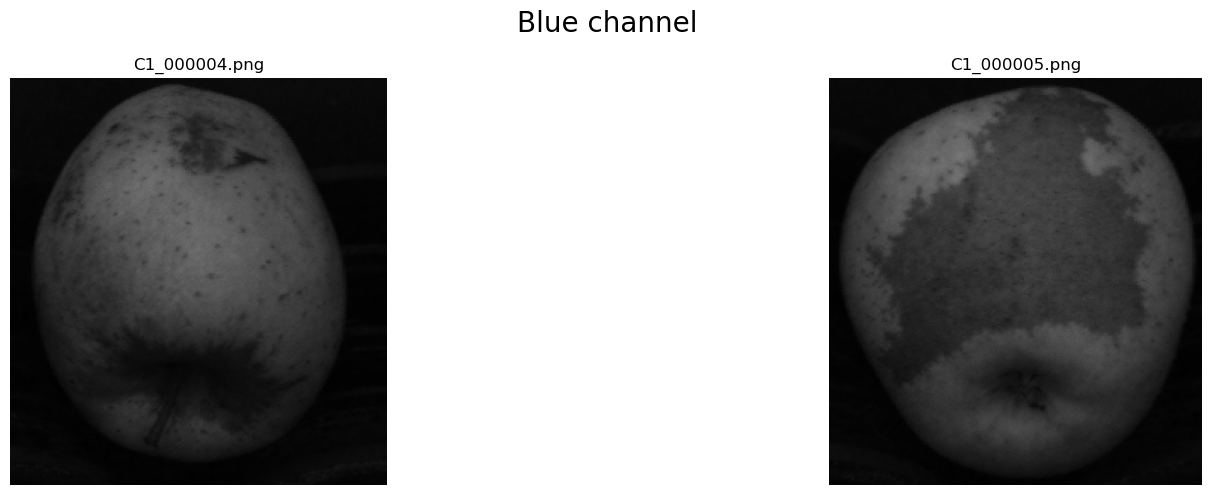

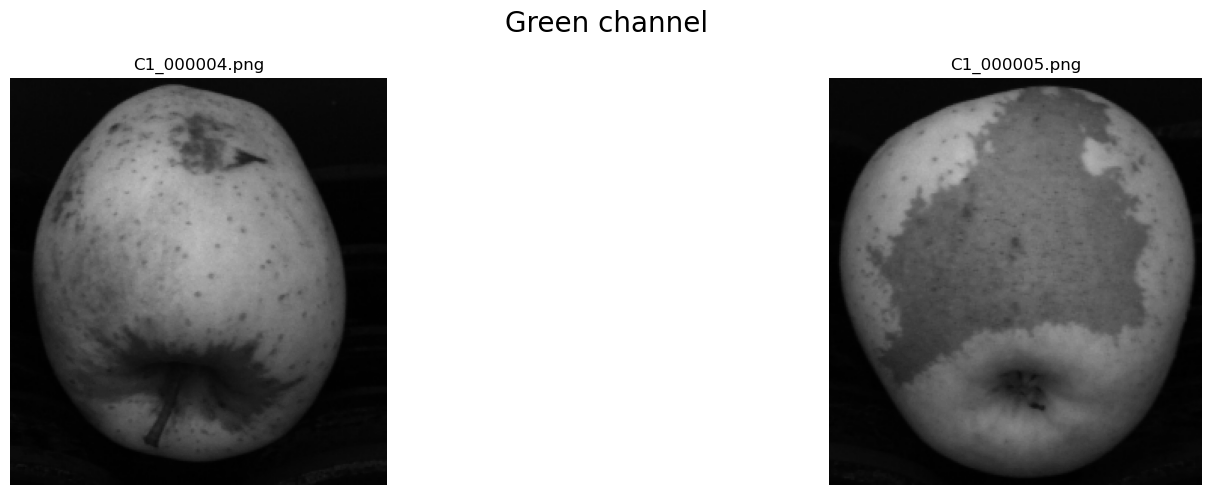

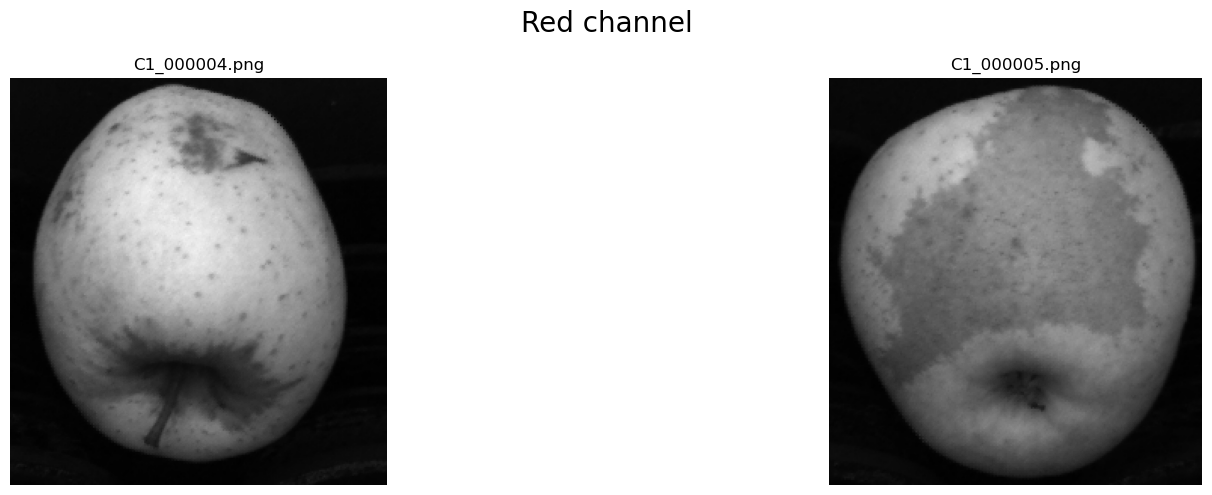

In [6]:
colour_B = []; colour_G = []; colour_R = []

for img in colour_imgs:
    B, G, R = cv2.split(img)
    colour_B.append(B)
    colour_G.append(G)
    colour_R.append(R)

# Plot the Channels of the images
plot_image_grid(colour_B, 'Blue channel', colour_names)
plot_image_grid(colour_G, 'Green channel', colour_names)
plot_image_grid(colour_R, 'Red channel', colour_names)

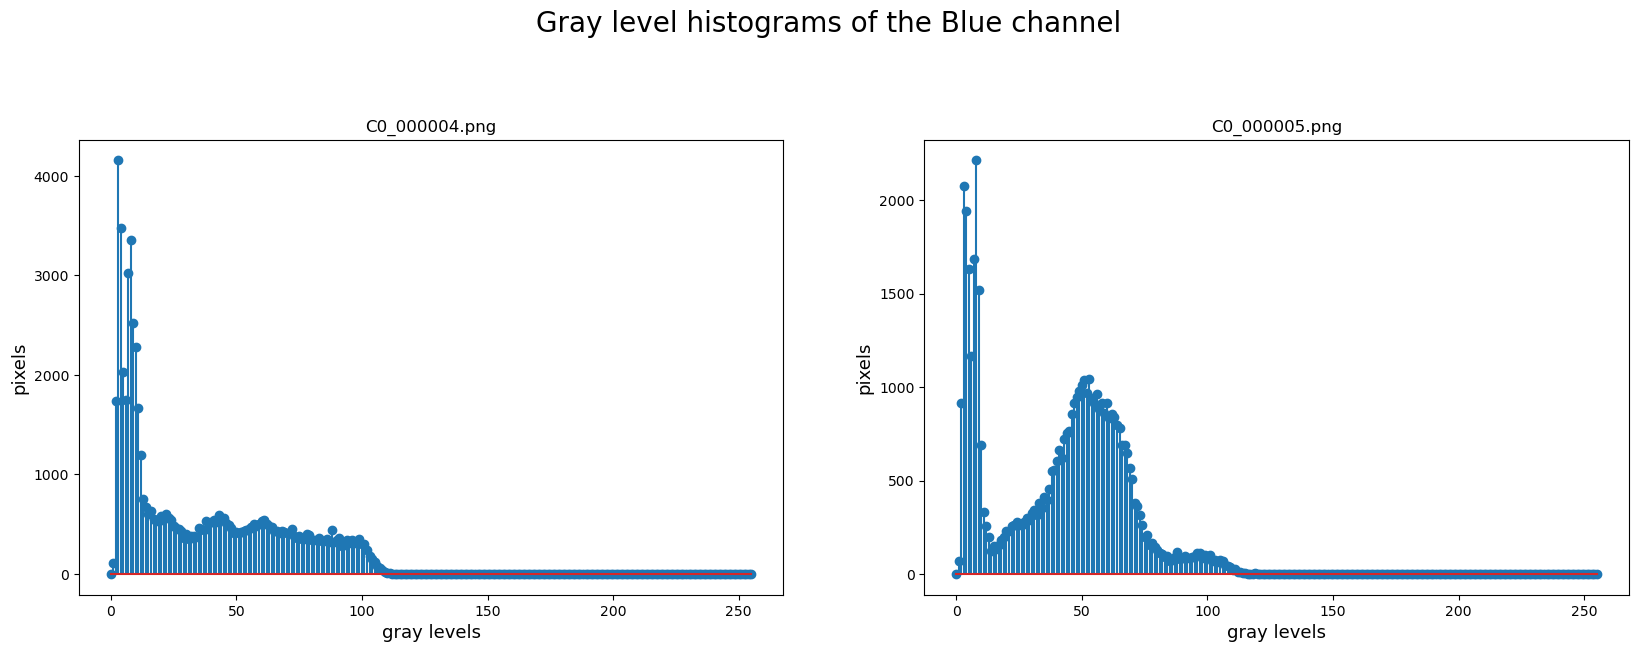

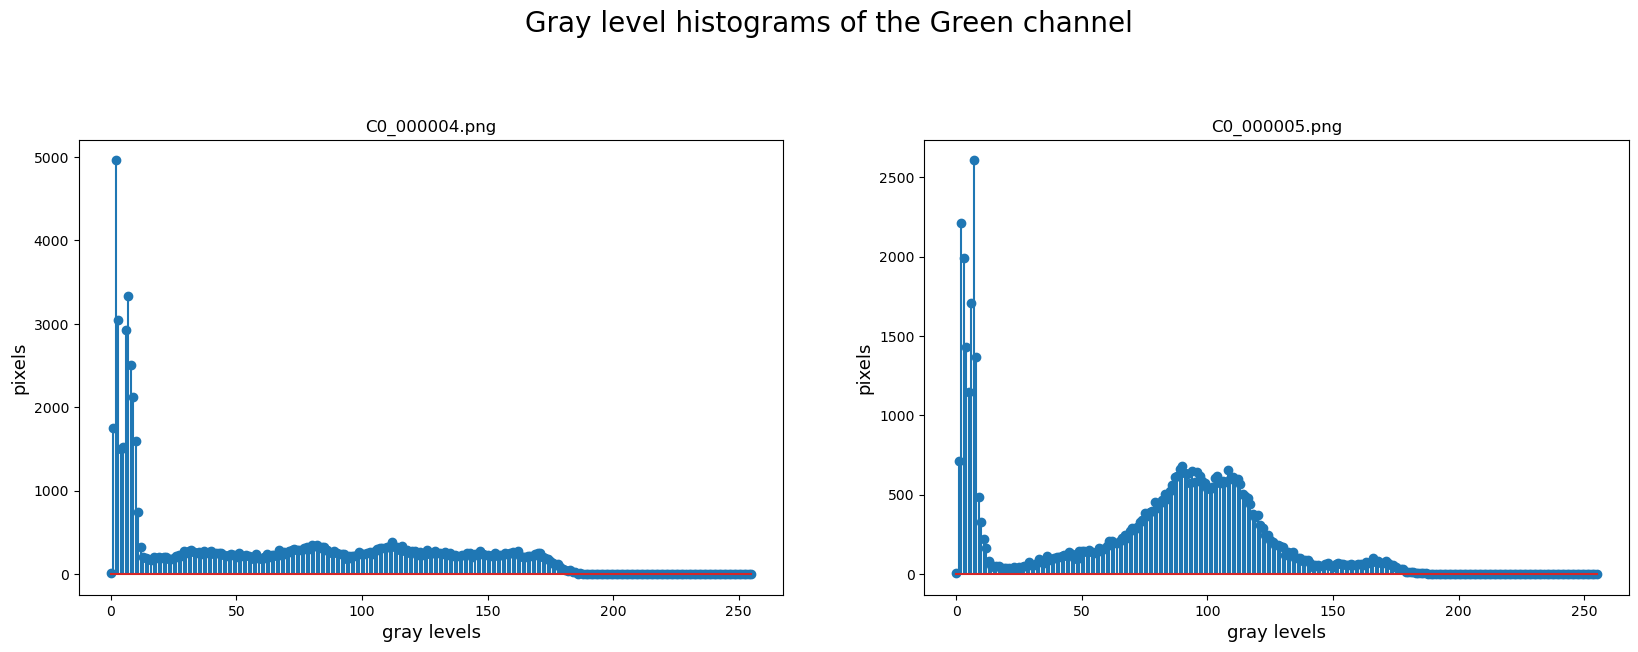

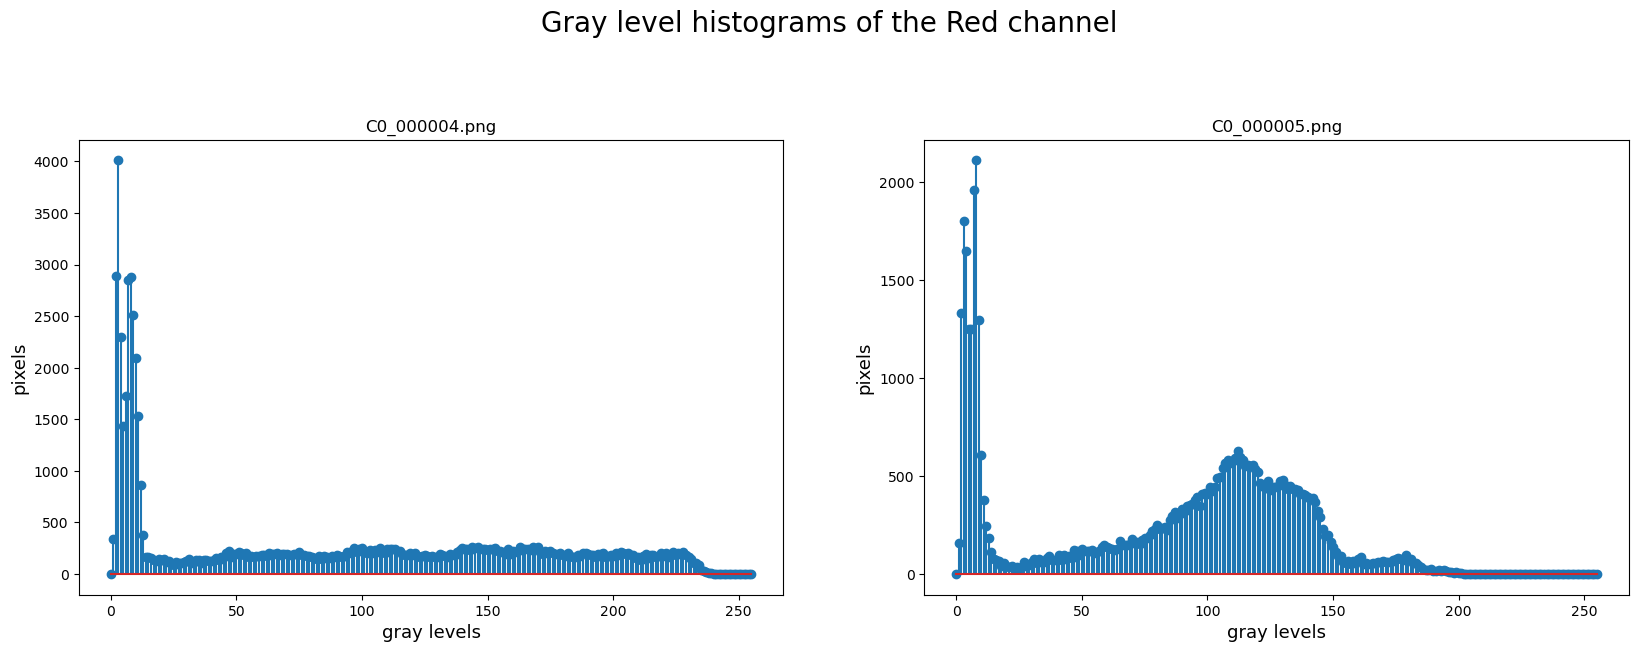

In [7]:
plot_histogram_grid(colour_B, 'Gray level histograms of the Blue channel', nir_names)
plot_histogram_grid(colour_G, 'Gray level histograms of the Green channel', nir_names)
plot_histogram_grid(colour_R, 'Gray level histograms of the Red channel', nir_names)

## todo 
- pack function to get mask in a utils package
- improve graphical representation (grid)

0.0


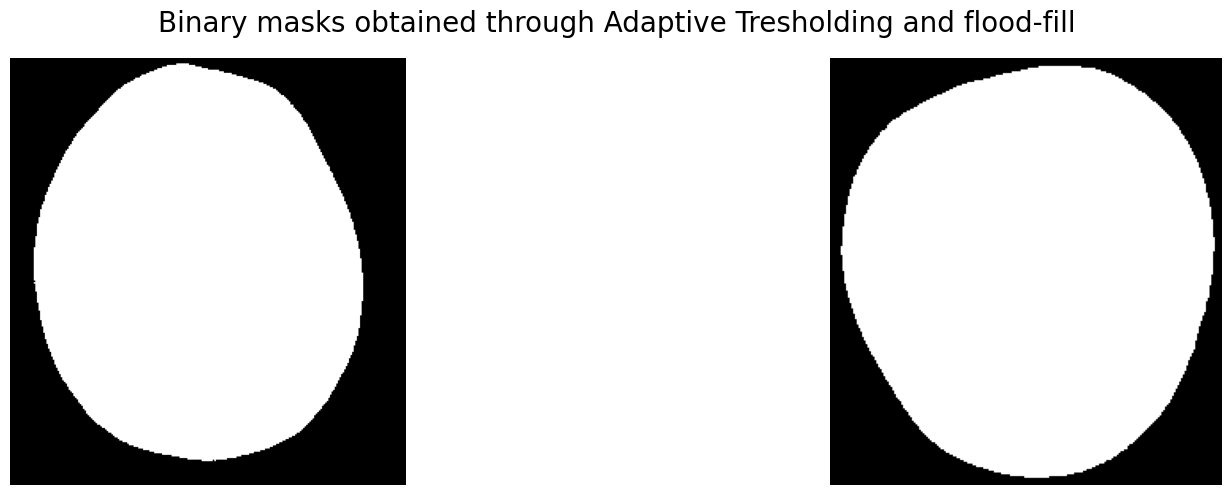

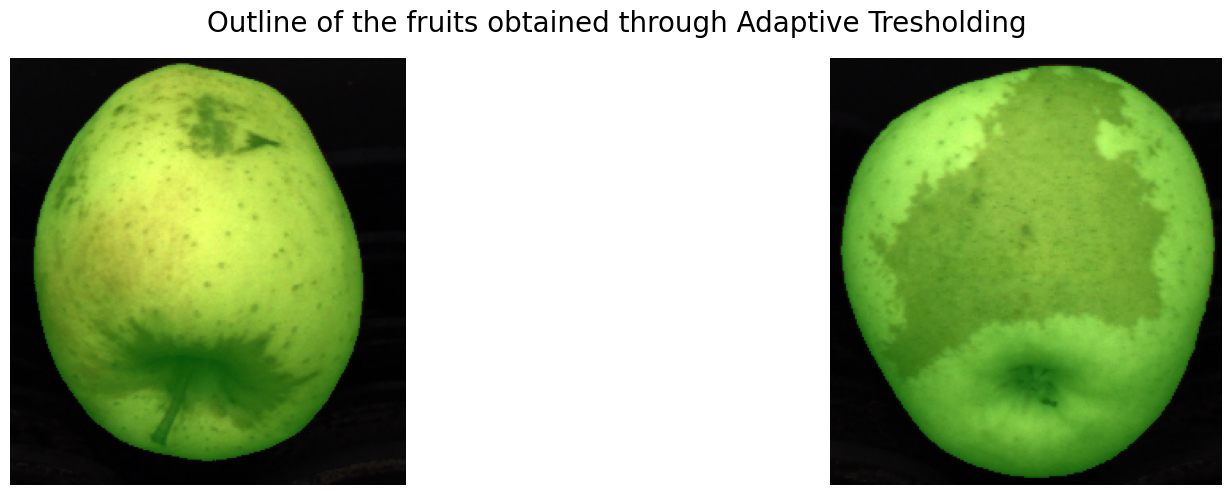

In [8]:
# obtaining the mask and preprocessing imgs

# median blur on images
filtered_colour_images = [cv2.medianBlur(img,5) for img in colour_imgs]

# greyscale image masking 

masks = []

s = process_time()
for img in filtered_colour_images:
    mask = cv2.adaptiveThreshold(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY), 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 11, 5)
    masks.append(mask)

# plot_image_grid(masks, 'Binary masks obtained through Adaptive Tresholding')
    
# Pad masks and flood-fill the background
masks = [np.pad(m, 1, mode='constant', constant_values=255) for m in masks]
for m in masks:
    cv2.floodFill(m, None, (0,0), 0)
# Downsample the masks to their original size
masks = [m[1:-1,1:-1] for m in masks]
print(process_time() - s)

# plot_image_grid(masks, 'Binary masks obtained through Adaptive Tresholding')

masks = [apply_flood_fill(i) for i in masks]

plot_image_grid(masks, 'Binary masks obtained through Adaptive Tresholding and flood-fill')

bounded_images = []

for idx, img in enumerate(colour_imgs):
    green_mask = cv2.cvtColor(masks[idx], cv2.COLOR_GRAY2BGR)
    # Force the bits of every channel except the green at 0
    green_mask[:,:,::2] = 0
    bounded_images.append(cv2.addWeighted(green_mask, 0.3, img, 1, 0))
    
plot_image_grid(bounded_images, 'Outline of the fruits obtained through Adaptive Tresholding')

In [9]:
# mask is applied to images
masked_filtered_imgs = [filtered_colour_images[i] & cv2.cvtColor(masks[i], cv2.COLOR_GRAY2BGR) for i in range(len(masks))]

In [10]:
def get_masked_color_space(img, mask, color_space):
    return cv2.cvtColor(img, color_space) #& cv2.cvtColor(mask,cv2.COLOR_GRAY2BGR)

In [11]:
"""# Create HSV, HLS, LUV images
colour_space_dict = {
    'BGR': masked_filtered_imgs,
    'HSV': [get_masked_color_space(img, masks[i], cv2.COLOR_BGR2HSV_FULL) for i, img in enumerate(filtered_colour_images)],
    'HLS': [get_masked_color_space(img, masks[i], cv2.COLOR_BGR2HLS_FULL) for i, img in enumerate(filtered_colour_images)],
    'LUV': [get_masked_color_space(img, masks[i], cv2.COLOR_BGR2Luv) for i, img in enumerate(filtered_colour_images)],
    'LAB': [get_masked_color_space(img, masks[i], cv2.COLOR_BGR2LAB) for i, img in enumerate(filtered_colour_images)],
    'YCrCb': [get_masked_color_space(img, masks[i], cv2.COLOR_BGR2YCrCb) for i, img in enumerate(filtered_colour_images)],
    'YUV': [get_masked_color_space(img, masks[i], cv2.COLOR_BGR2YUV) for i, img in enumerate(filtered_colour_images)]
}"""

"# Create HSV, HLS, LUV images\ncolour_space_dict = {\n    'BGR': masked_filtered_imgs,\n    'HSV': [get_masked_color_space(img, masks[i], cv2.COLOR_BGR2HSV_FULL) for i, img in enumerate(filtered_colour_images)],\n    'HLS': [get_masked_color_space(img, masks[i], cv2.COLOR_BGR2HLS_FULL) for i, img in enumerate(filtered_colour_images)],\n    'LUV': [get_masked_color_space(img, masks[i], cv2.COLOR_BGR2Luv) for i, img in enumerate(filtered_colour_images)],\n    'LAB': [get_masked_color_space(img, masks[i], cv2.COLOR_BGR2LAB) for i, img in enumerate(filtered_colour_images)],\n    'YCrCb': [get_masked_color_space(img, masks[i], cv2.COLOR_BGR2YCrCb) for i, img in enumerate(filtered_colour_images)],\n    'YUV': [get_masked_color_space(img, masks[i], cv2.COLOR_BGR2YUV) for i, img in enumerate(filtered_colour_images)]\n}"

In [12]:
# Create HSV, HLS, LUV images
colour_space_dict = {
    'BGR': masked_filtered_imgs,
    'HSV': [get_masked_color_space(img, masks[i], cv2.COLOR_BGR2HSV_FULL) for i, img in enumerate(masked_filtered_imgs)],
    'HLS': [get_masked_color_space(img, masks[i], cv2.COLOR_BGR2HLS_FULL) for i, img in enumerate(masked_filtered_imgs)],
    'LUV': [get_masked_color_space(img, masks[i], cv2.COLOR_BGR2Luv) for i, img in enumerate(masked_filtered_imgs)],
    'LAB': [get_masked_color_space(img, masks[i], cv2.COLOR_BGR2LAB) for i, img in enumerate(masked_filtered_imgs)],
    'YCrCb': [get_masked_color_space(img, masks[i], cv2.COLOR_BGR2YCrCb) for i, img in enumerate(masked_filtered_imgs)],
    'YUV': [get_masked_color_space(img, masks[i], cv2.COLOR_BGR2YUV) for i, img in enumerate(masked_filtered_imgs)]
}

In [13]:
def show_split_channels(imgs, colour_space_name, imgs_names=None):
    for i, img in enumerate(imgs):
        plot_image_grid(cv2.split(img), f'{colour_space_name} Channel division for image {colour_names[i]}', imgs_names)

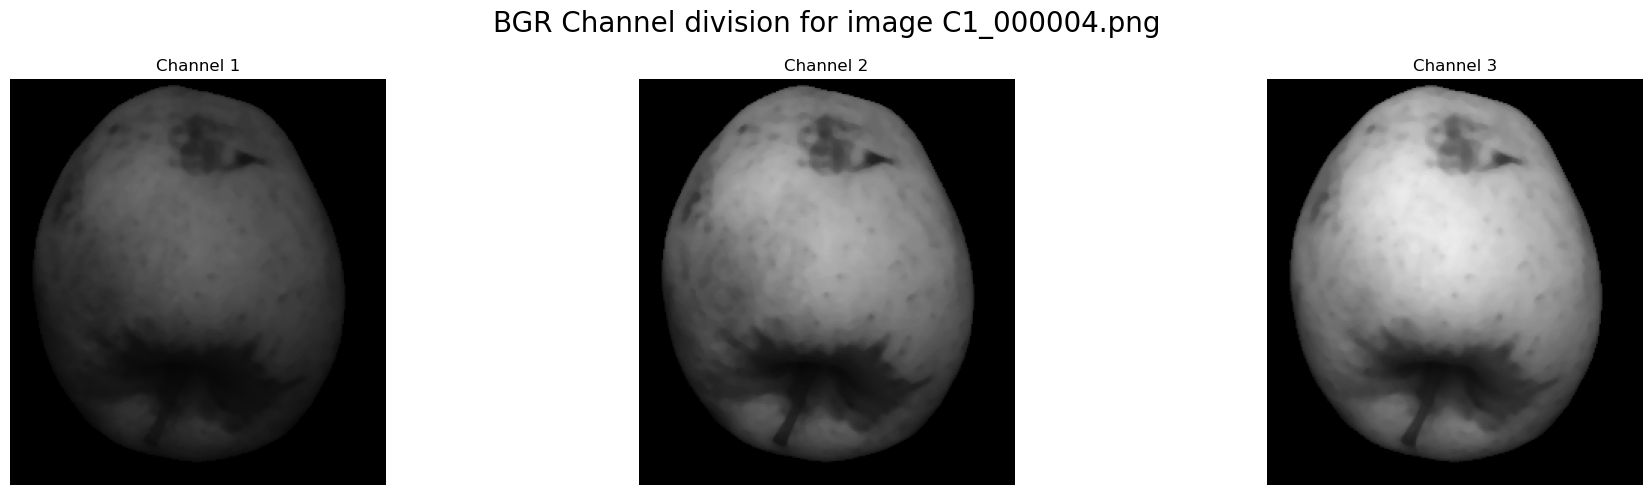

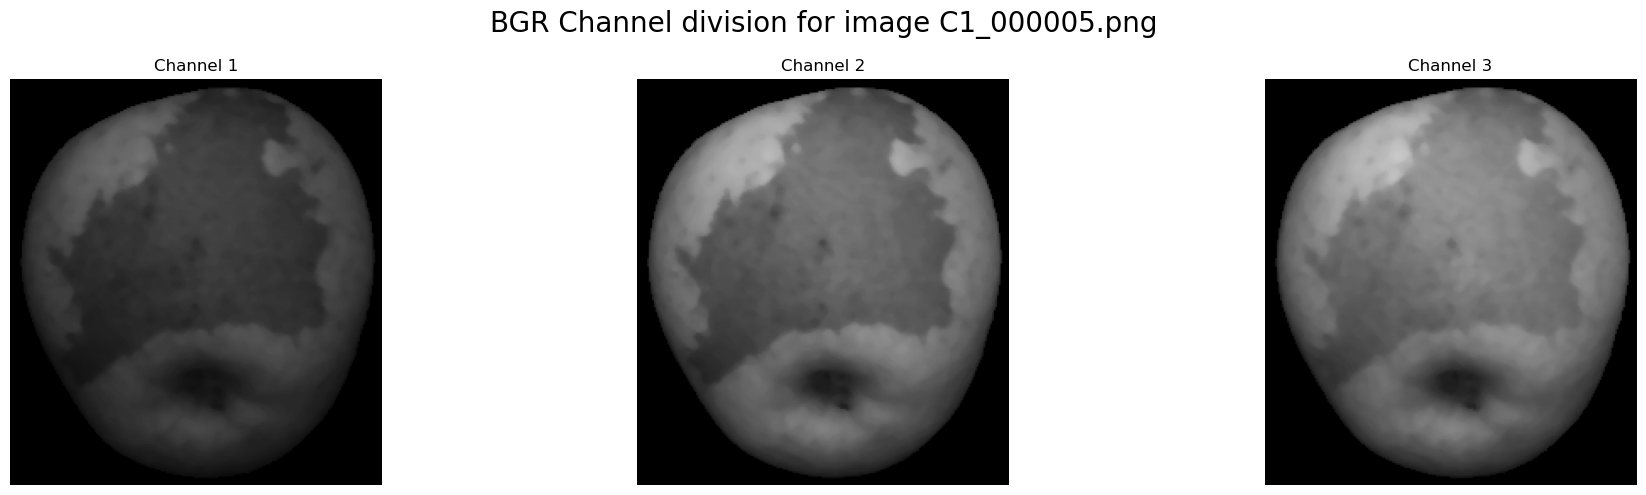

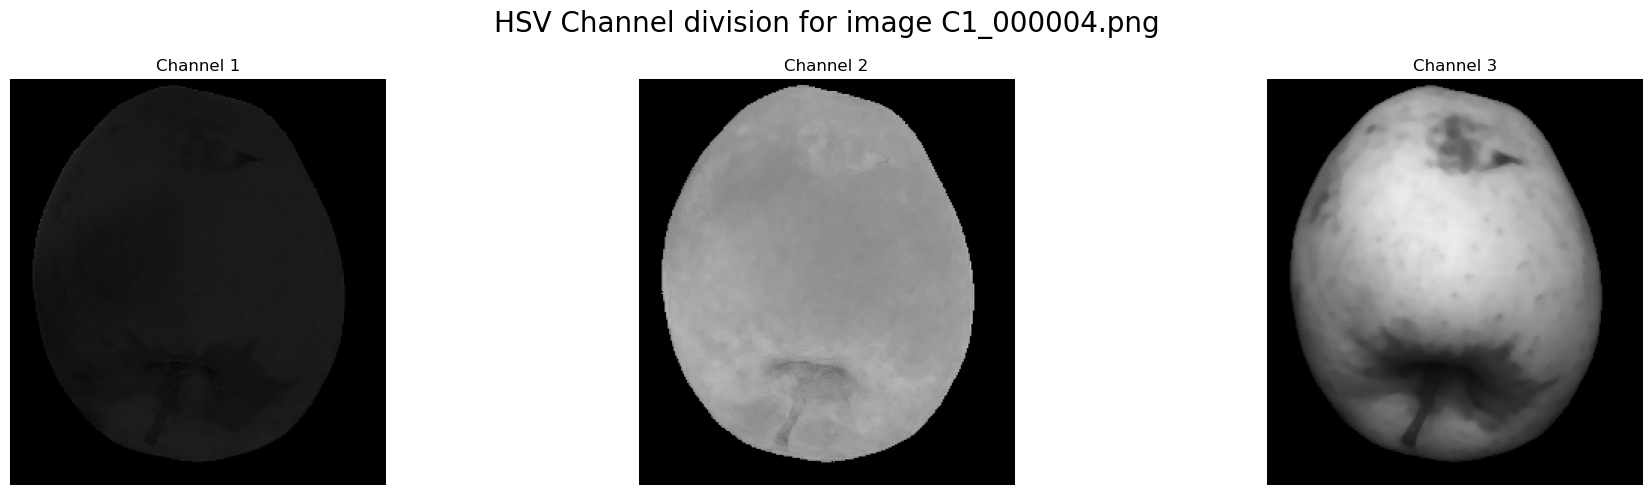

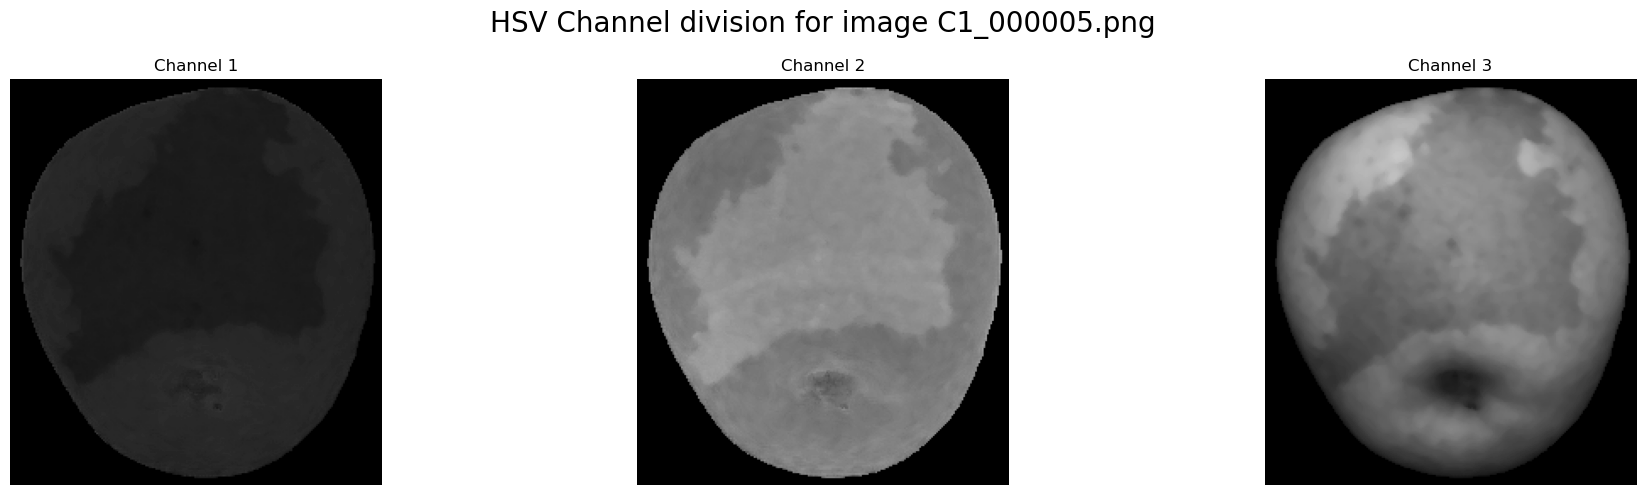

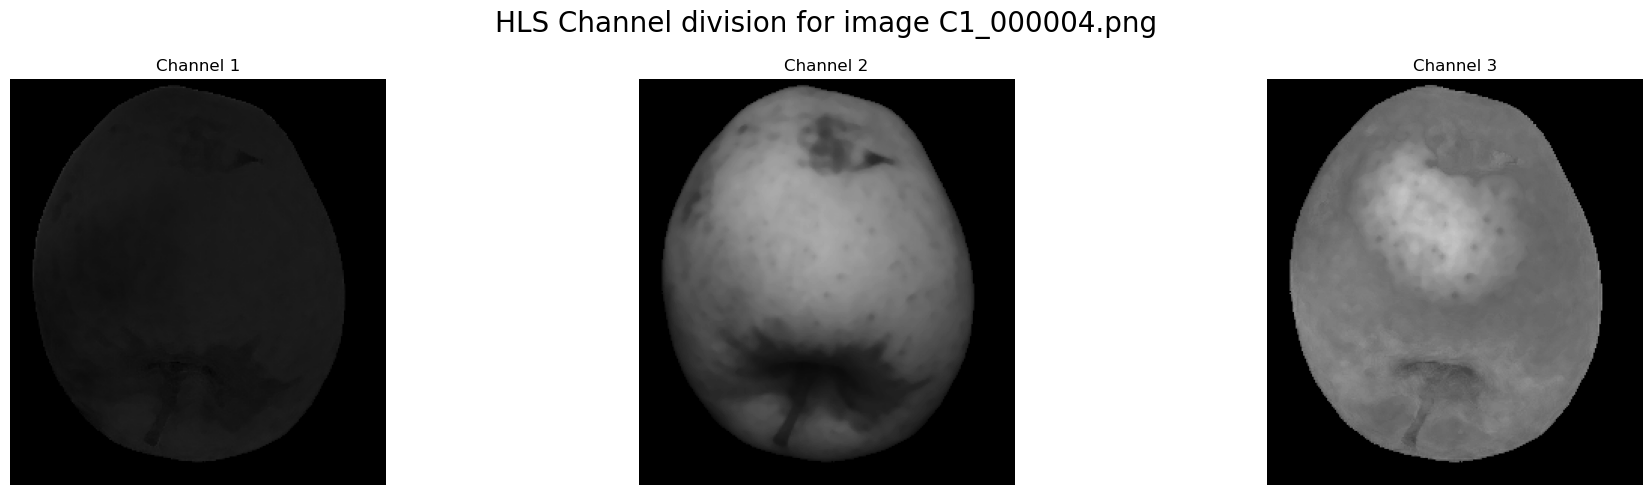

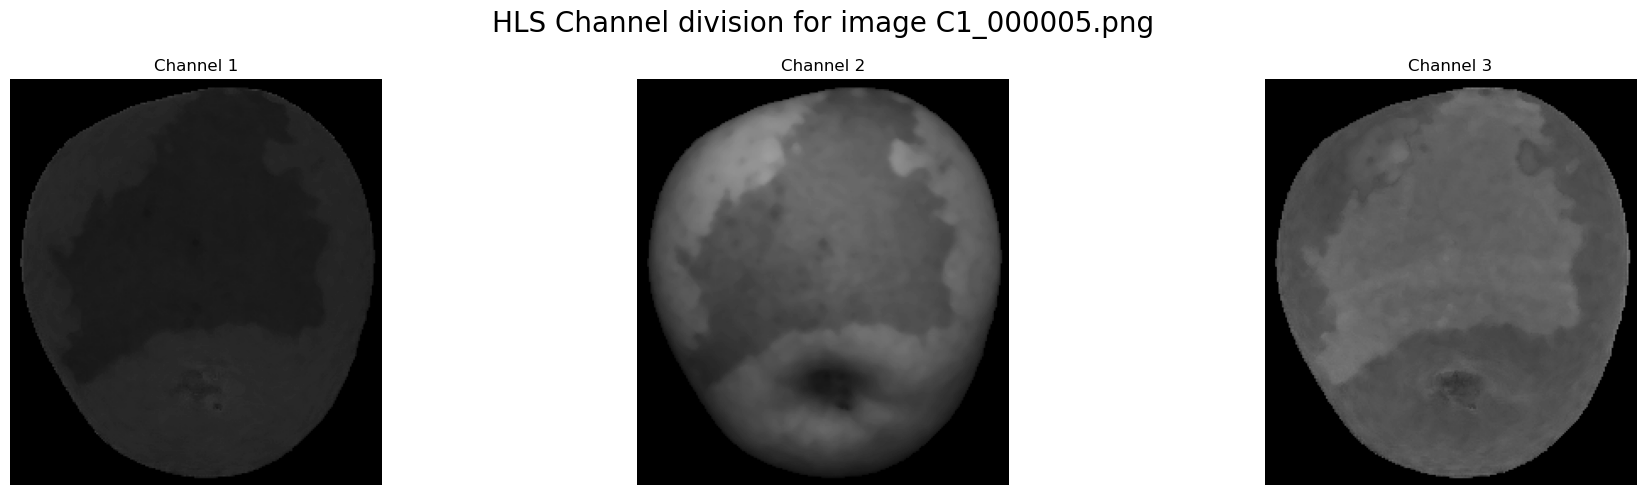

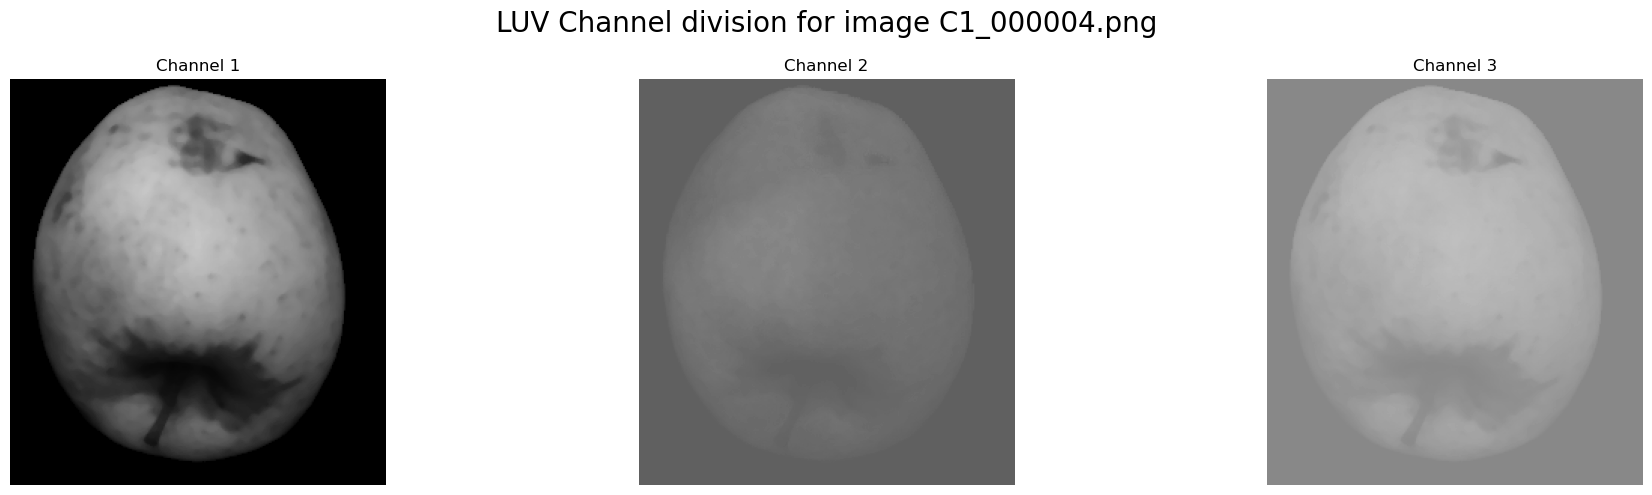

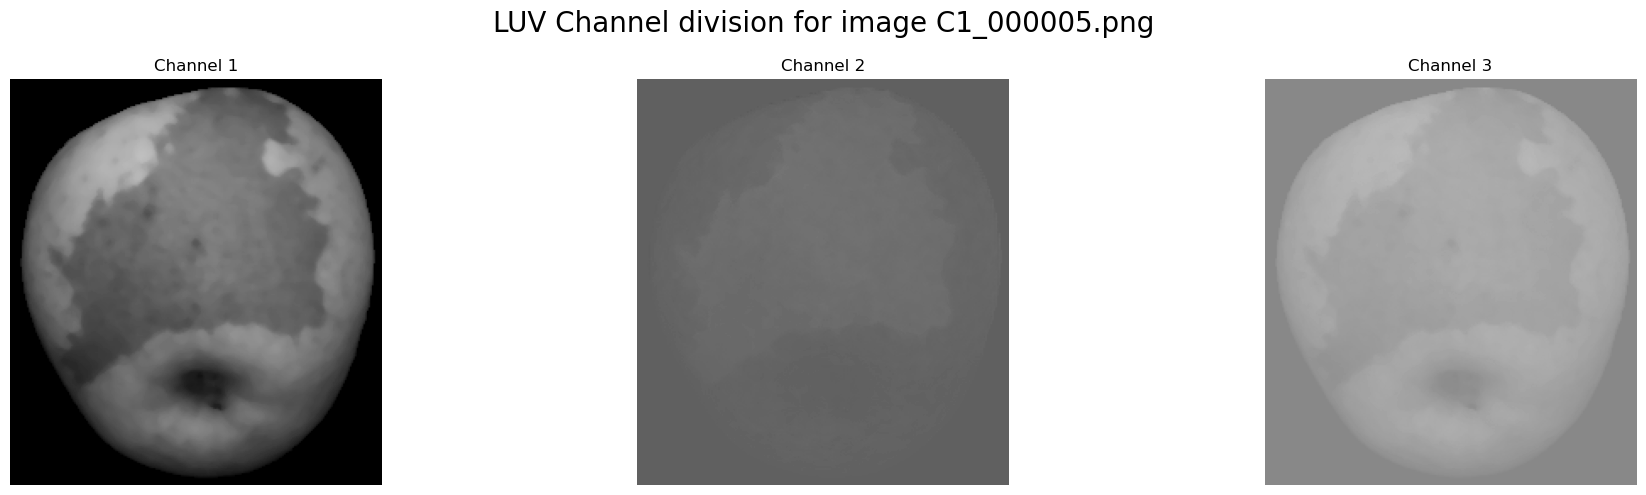

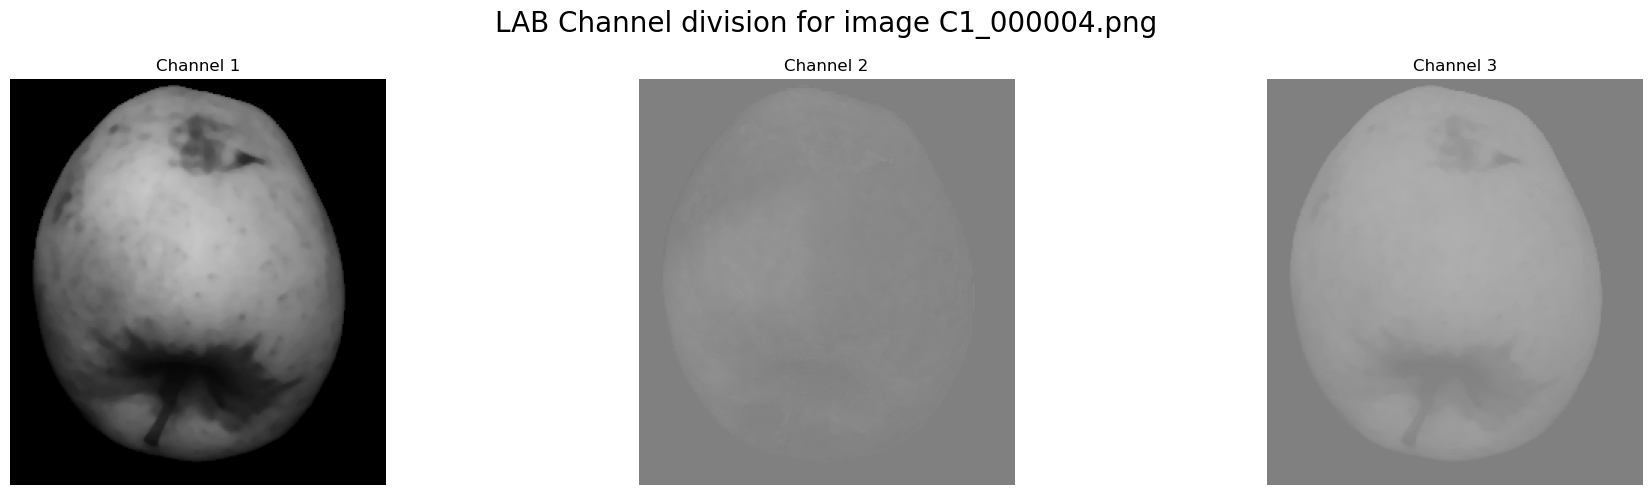

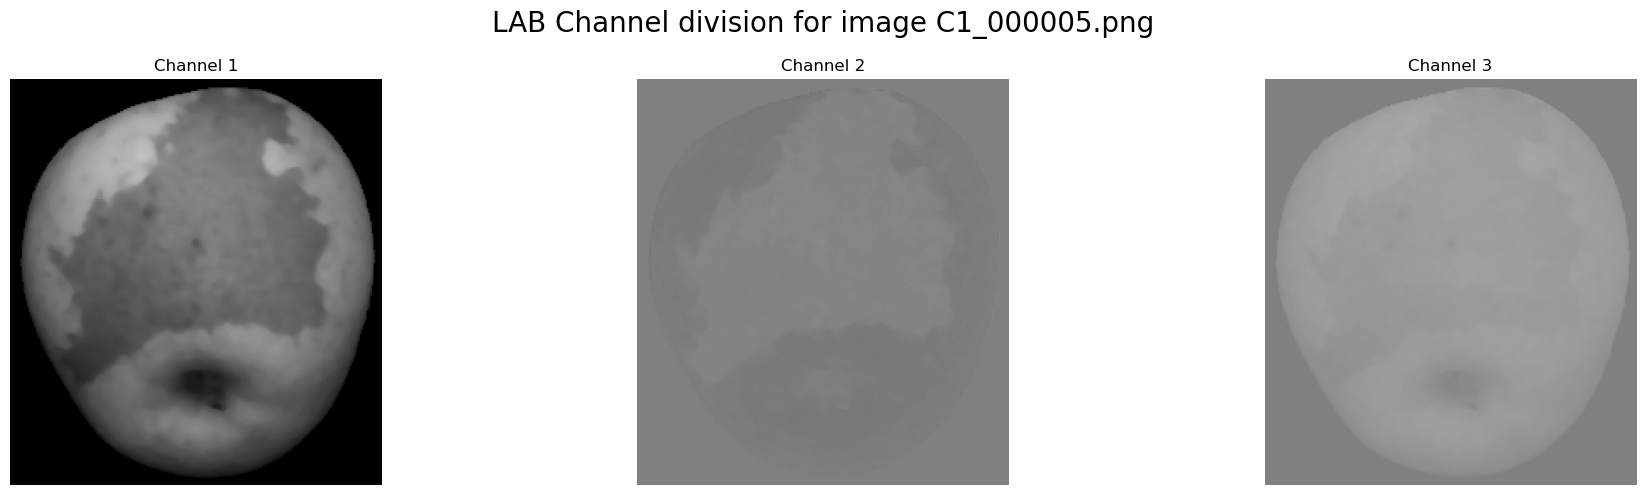

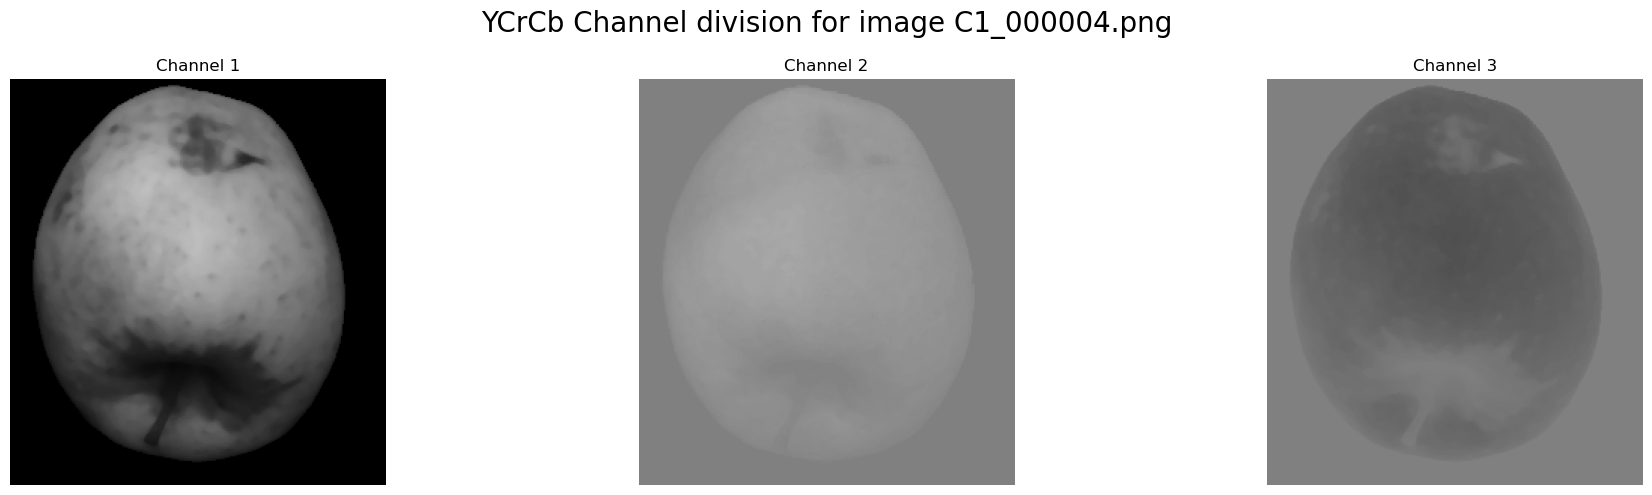

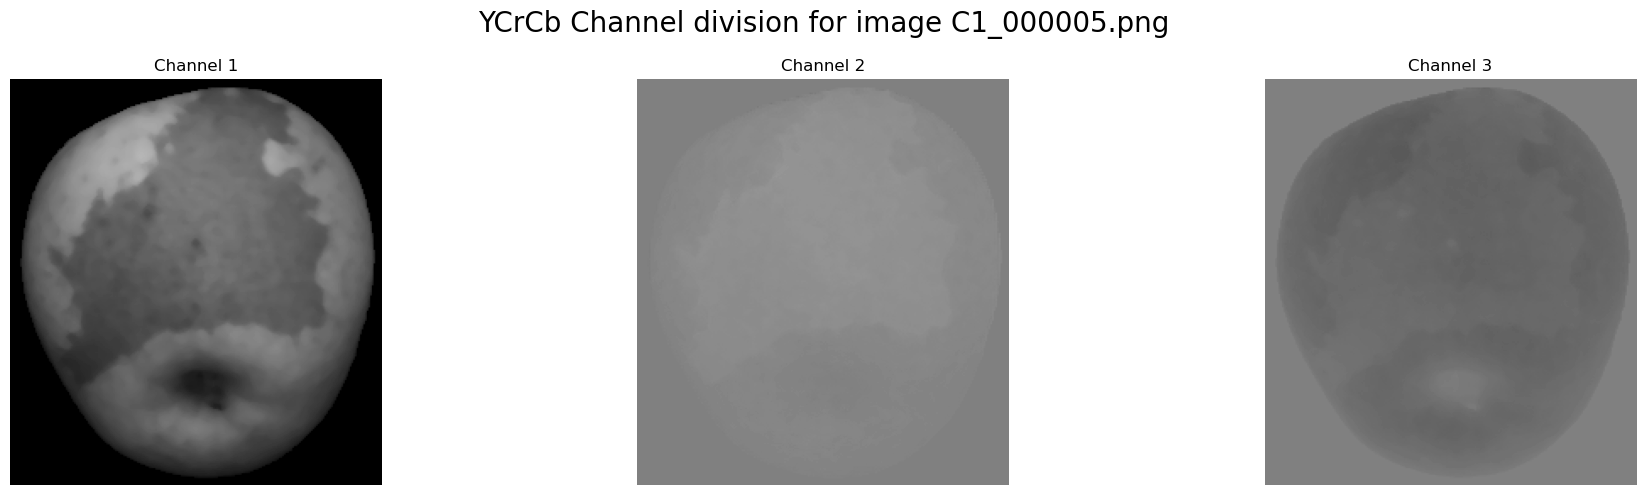

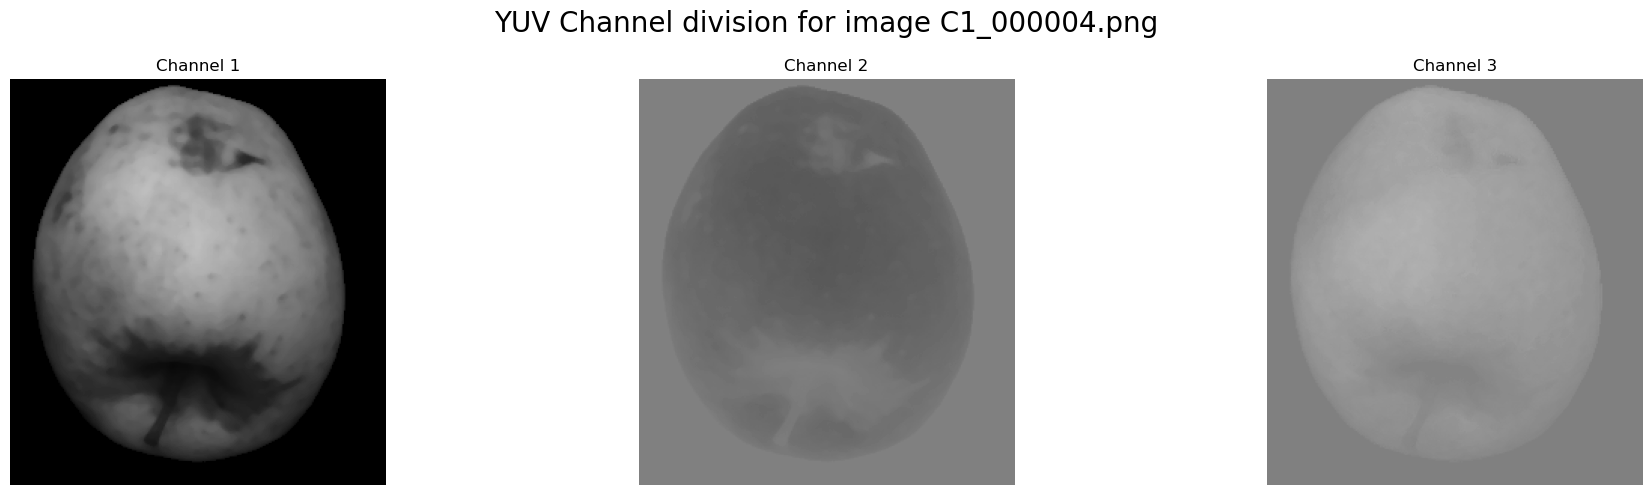

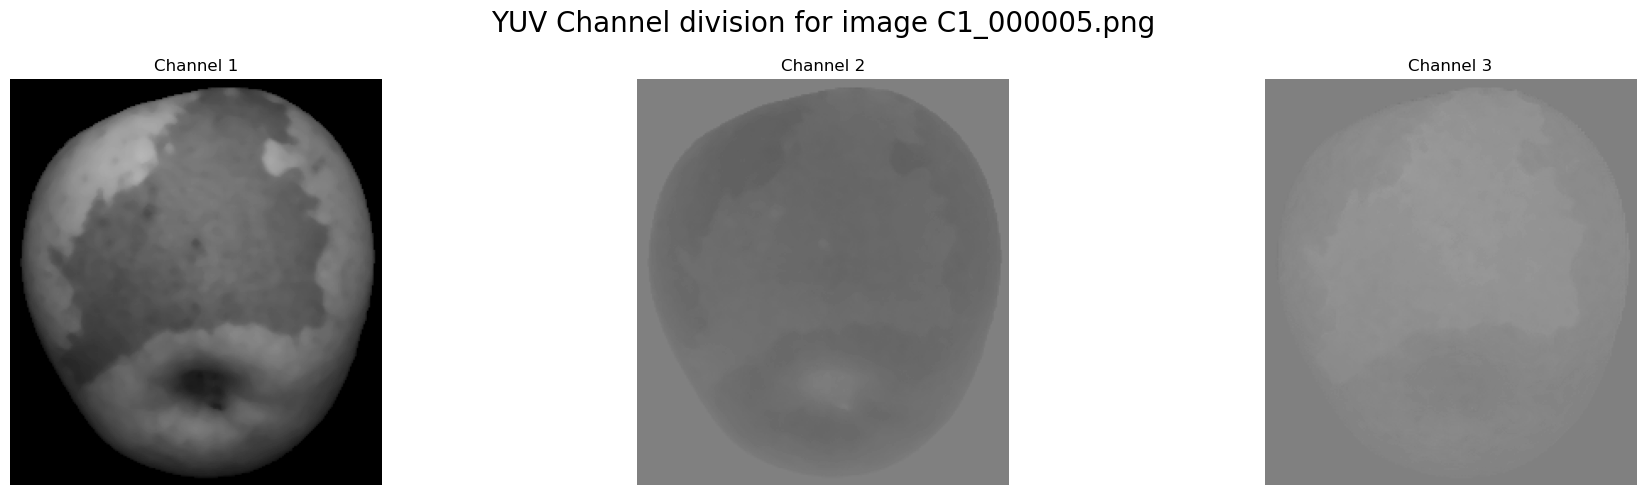

In [14]:
for k in colour_space_dict:
    show_split_channels(colour_space_dict[k], k, imgs_names=[f'Channel {i}' for i in range(1, 4)])

In [15]:
#
colour_space_significant_channels_dict = {
    'BGR': [0, 1, 2],
    'HSV': [0, 1],
    'HLS': [0, 2],
    'LUV': [1, 2],
    'LAB': [1, 2],
    'YCrCb': [1, 2],
    'YUV': [1, 2]
}

In [16]:
def get_k_means_segmentation(img, channels):
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.)
    flags = cv2.KMEANS_RANDOM_CENTERS
    Z = np.copy(img)
    Z = Z[:,:,channels]
    Z = Z.reshape(-1,len(channels))
    Z = np.float32(Z)
    centers = 3

    _, labels, _ = cv2.kmeans(Z, centers, None, criteria, 10, flags)

    labels[labels == 1] = 255 // 2
    labels[labels == 2] = 255
    res = labels.reshape(img.shape[0], img.shape[1])

    return res.astype('uint8')

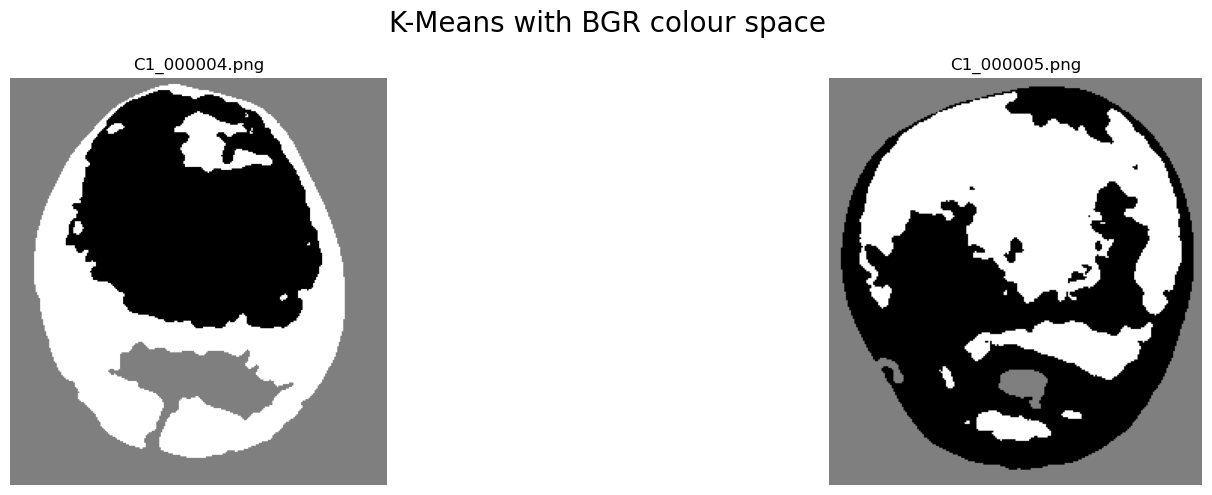

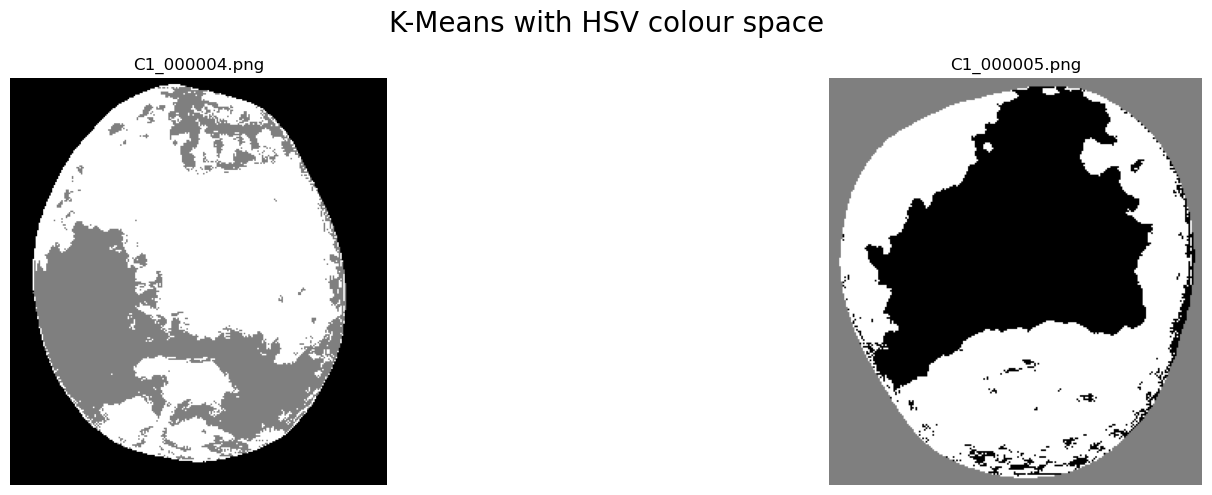

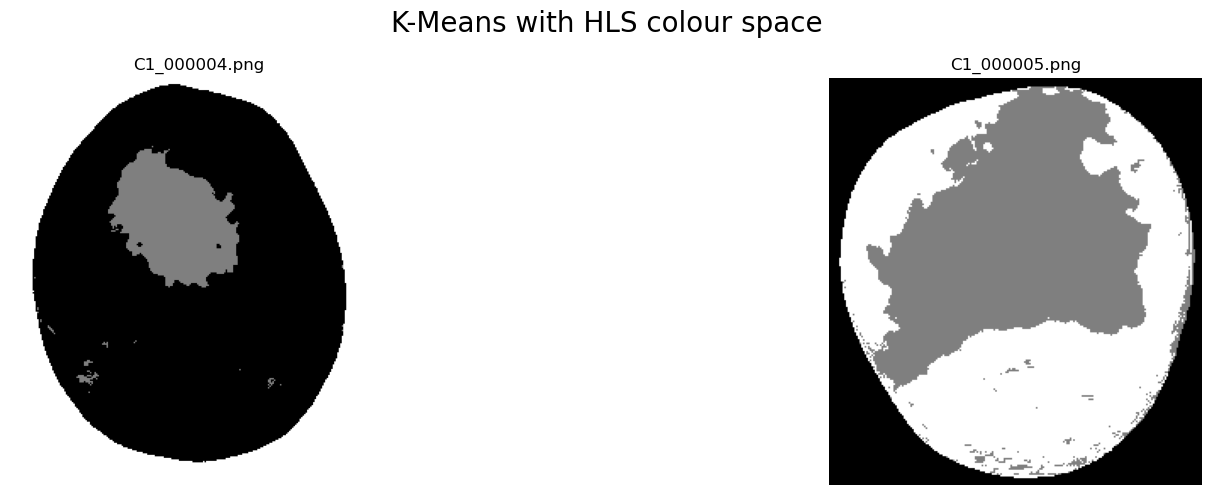

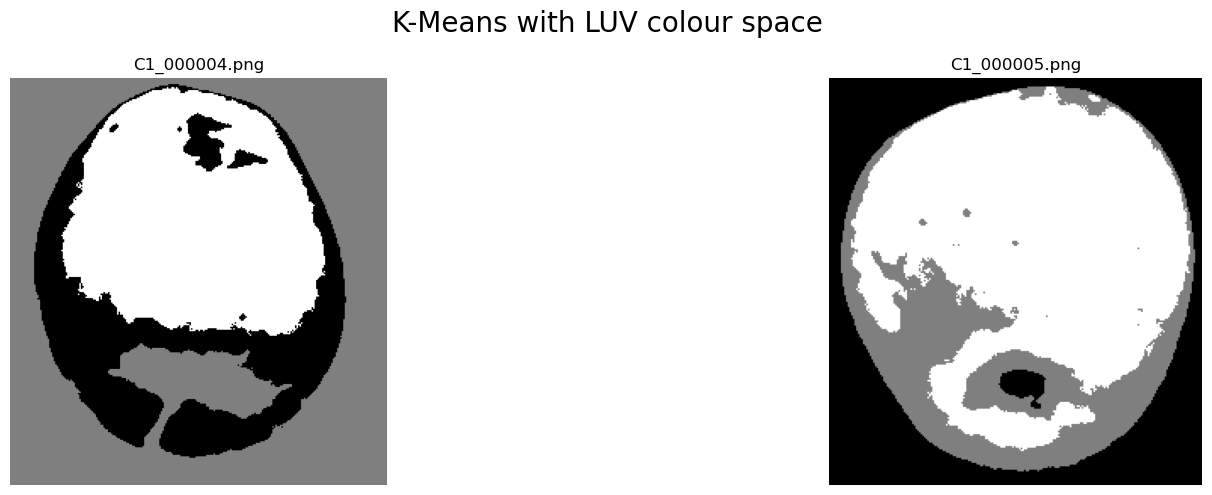

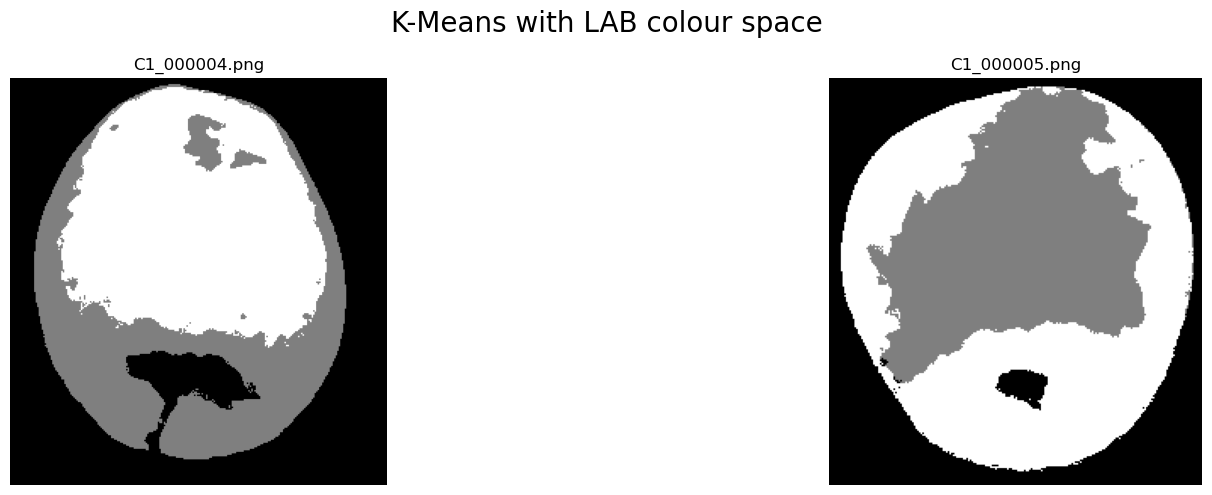

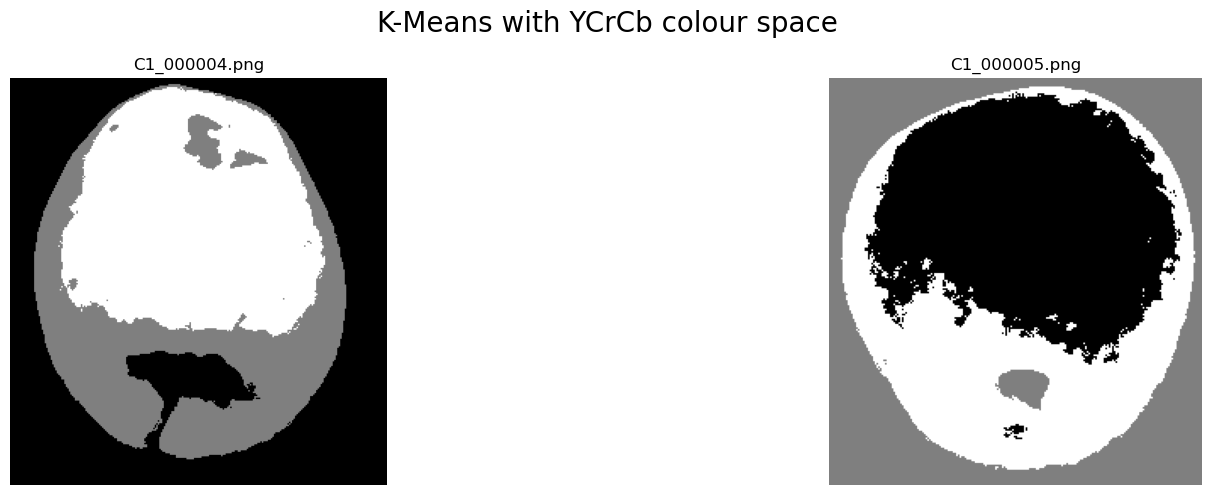

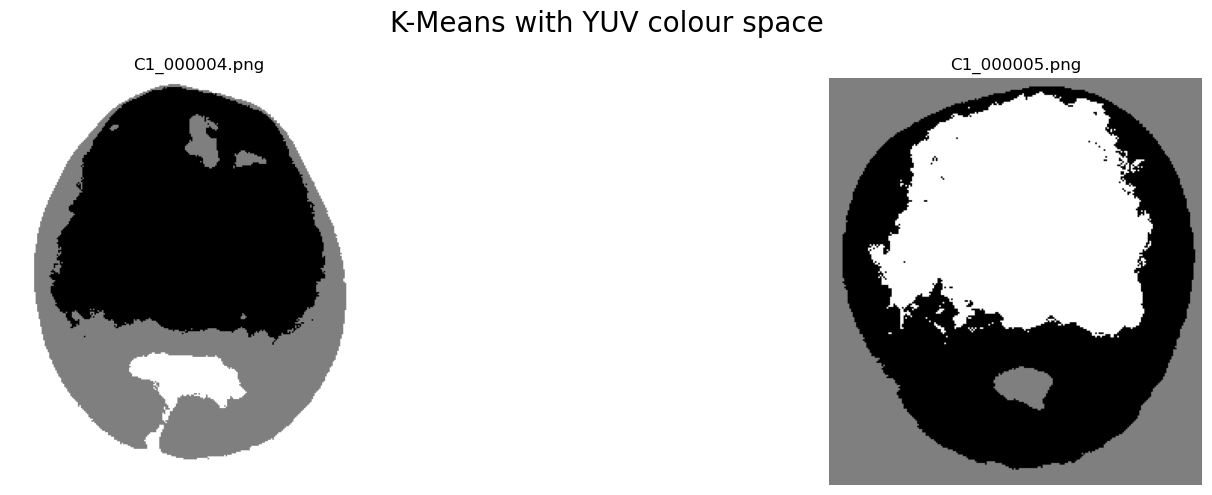

In [17]:

for k in colour_space_dict:
    res = []
    for img in colour_space_dict[k]:
        res.append(get_k_means_segmentation(img, colour_space_significant_channels_dict[k]))
    plot_image_grid(res, f'K-Means with {k} colour space', colour_names)

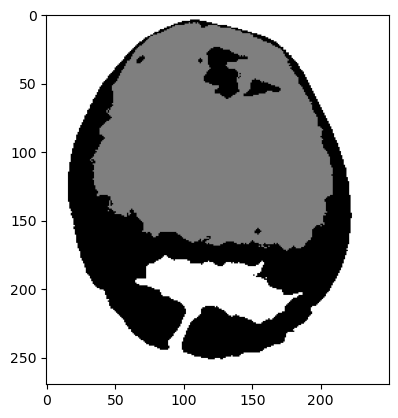

In [18]:
kmeans_luv = get_k_means_segmentation(colour_space_dict['LUV'][0], colour_space_significant_channels_dict['LUV'])
plt.imshow(kmeans_luv, cmap='gray', vmin=0, vmax=255)
plt.show()

In [19]:
element = cv2.getStructuringElement(0, (15, 15))
eroded_mask = cv2.erode(masks[0], element)

In [20]:
roi_1_1_mask = kmeans_luv & eroded_mask
roi_1_1_mask[roi_1_1_mask == 255 // 2] = 0

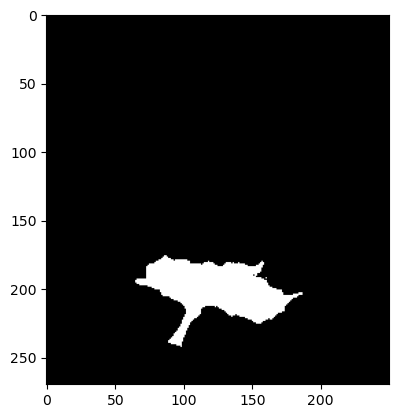

In [21]:
plt.imshow(roi_1_1_mask, cmap='gray', vmin=0, vmax=255)
plt.show()

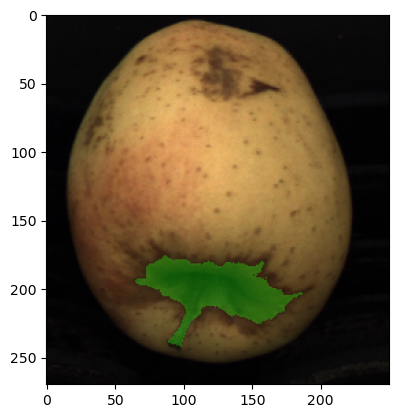

In [22]:
green_mask = cv2.cvtColor(roi_1_1_mask, cv2.COLOR_GRAY2BGR)
# Force the bits of every channel except the green at 0
green_mask[:,:,::2] = 0
highlighted_roi = cv2.addWeighted(green_mask, 0.3, colour_imgs[0], 1, 0)
plt.imshow(cv2.cvtColor(highlighted_roi, cv2.COLOR_BGR2RGB))
plt.show()

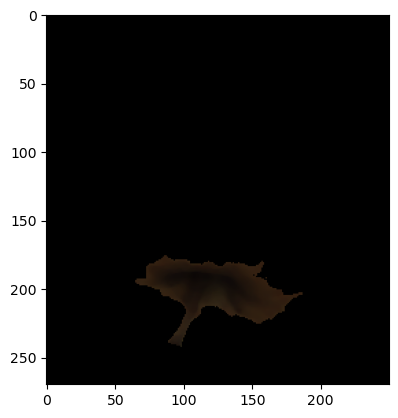

In [24]:
roi_1_1 = masked_filtered_imgs[0] & cv2.cvtColor(roi_1_1_mask, cv2.COLOR_GRAY2BGR)
plt.imshow(cv2.cvtColor(roi_1_1, cv2.COLOR_BGR2RGB))
plt.show()

In [26]:
roi_1_2_mask = np.copy(kmeans_luv)
cv2.floodFill(roi_1_2_mask, None, (0, 0), 0)
cv2.floodFill(roi_1_2_mask, None, (0, 0), 255 // 2)
roi_1_2_mask[roi_1_2_mask == 0] = 255
roi_1_2_mask[roi_1_2_mask == 255 // 2] = 0

In [27]:
'''green_mask = cv2.cvtColor(roi_1_2_mask, cv2.COLOR_GRAY2BGR)
# Force the bits of every channel except the green at 0
green_mask[:,:,::2] = 0
highlighted_roi = cv2.addWeighted(green_mask, 0.3, colour_imgs[0], 1, 0)
plt.imshow(cv2.cvtColor(highlighted_roi, cv2.COLOR_BGR2RGB))
plt.show()''';

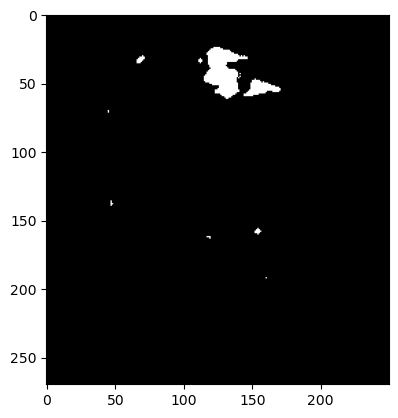

In [28]:
plt.imshow(roi_1_2_mask, cmap='gray', vmin=0, vmax=255)
plt.show()

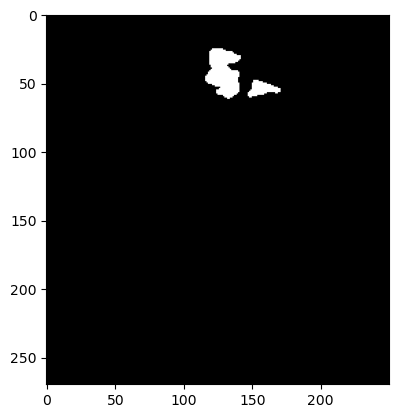

In [29]:
element = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (4, 4))
roi_1_2_mask = cv2.morphologyEx(roi_1_2_mask, cv2.MORPH_OPEN, element)
plt.imshow(roi_1_2_mask, cmap='gray', vmin=0, vmax=255)
plt.show()

In [30]:
#roi_1_2_mask =  kmeans_luv_roi_1 + kmeans_luv_roi_2

In [31]:
#plt.imshow(roi_mask_1, cmap='gray', vmin=0, vmax=255)
#plt.show()

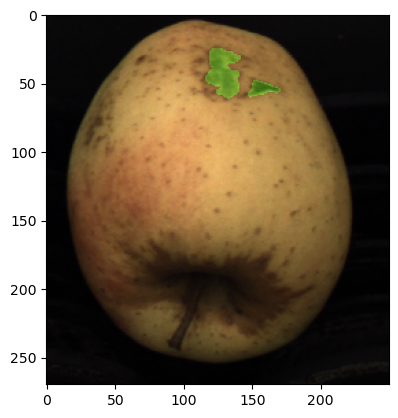

In [32]:
green_mask = cv2.cvtColor(roi_1_2_mask, cv2.COLOR_GRAY2BGR)
# Force the bits of every channel except the green at 0
green_mask[:,:,::2] = 0
highlighted_roi = cv2.addWeighted(green_mask, 0.3, colour_imgs[0], 1, 0)
plt.imshow(cv2.cvtColor(highlighted_roi, cv2.COLOR_BGR2RGB))
plt.show()

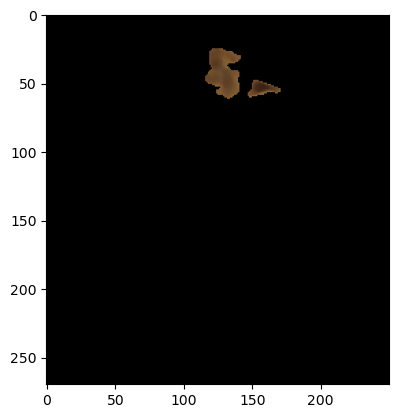

In [34]:
roi_1_2 = masked_filtered_imgs[0] & cv2.cvtColor(roi_1_2_mask, cv2.COLOR_GRAY2BGR)
plt.imshow(cv2.cvtColor(roi_1_2, cv2.COLOR_BGR2RGB))
plt.show()

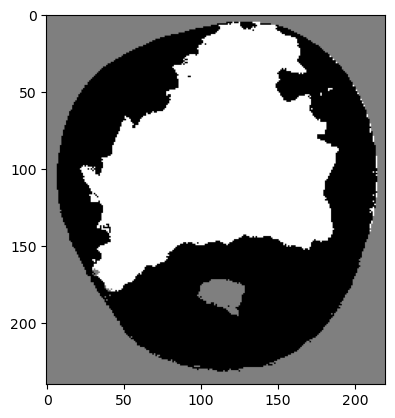

In [35]:
# We take just the LAB color space 
# We take just second kmeans image as a sample
kmeans_lab = get_k_means_segmentation(colour_space_dict['LAB'][1], colour_space_significant_channels_dict['LAB'])
plt.imshow(kmeans_lab, cmap='gray', vmin=0, vmax=255)
plt.show()

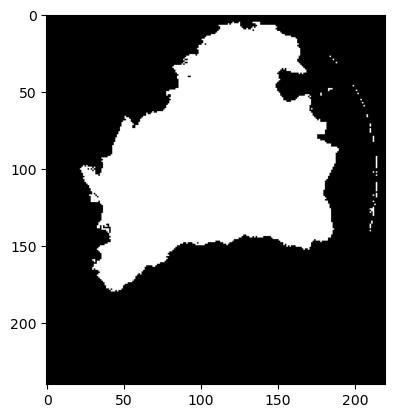

In [36]:
kmeans_lab[kmeans_lab == 255 // 2] = 0
# kmeans_lab[kmeans_lab == 255 // 2] = 255
roi_mask_2 = kmeans_lab
plt.imshow(roi_mask_2, cmap='gray', vmin=0, vmax=255)
plt.show()

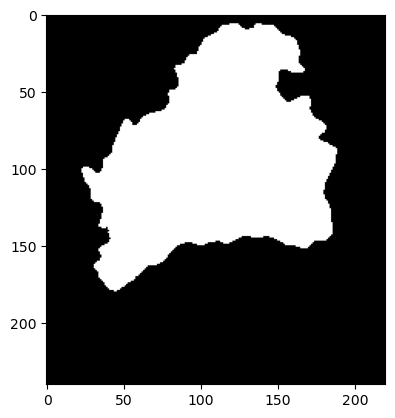

In [37]:
roi_mask_2 = cv2.medianBlur(roi_mask_2, 5)
plt.imshow(roi_mask_2, cmap='gray', vmin=0, vmax=255)
plt.show()

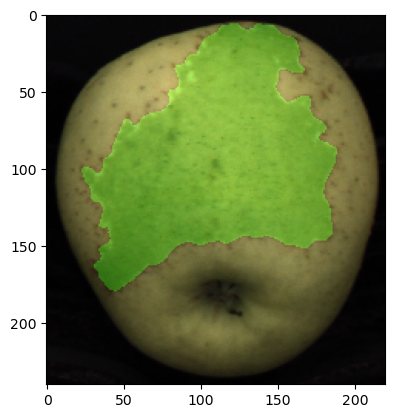

In [38]:
green_mask = cv2.cvtColor(roi_mask_2, cv2.COLOR_GRAY2BGR)
# Force the bits of every channel except the green at 0
green_mask[:,:,::2] = 0
highlighted_roi = cv2.addWeighted(green_mask, 0.3, colour_imgs[1], 1, 0)
plt.imshow(cv2.cvtColor(highlighted_roi, cv2.COLOR_BGR2RGB))
plt.show()

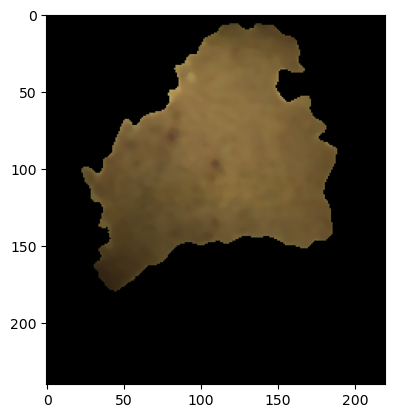

In [39]:
roi_2 = masked_filtered_imgs[1] & cv2.cvtColor(roi_mask_2, cv2.COLOR_GRAY2BGR)
plt.imshow(cv2.cvtColor(roi_2, cv2.COLOR_BGR2RGB))
plt.show()

## Extracting patches for each ROI

In [43]:
def get_samples(roi, num_samples, patch_size):
    # Get all patches of size (`patch_size`, `patch_size`) from the image
    patches = list(extract_patches_2d(roi, (patch_size, patch_size), random_state=SEED))
    # Extract just the patches of the ROI
    roi_patches = [p for p in patches if np.all(p)]
    # Get index of `num_samples` randomly chosen samples
    samples_idx = np.random.choice(np.arange(len(roi_patches)), num_samples, replace=False)
    # Get samples based on the obtained random indices
    return [roi_patches[i] for i in samples_idx]

In [44]:
#TOTAL_NUM_PATCHES = 1_000

In [255]:
samples = get_samples(roi_1_1, 200, 10)
samples += get_samples(roi_1_2, 200, 7)
samples += get_samples(roi_2, 200, 10)

In [256]:
'''patches_1 = list(extract_patches_2d(roi_1, (3, 3)))
roi_1_patches = [p for p in patches_1 if np.all(p)]
print(len(roi_1_patches))
samples_idx = np.random.choice(np.arange(len(roi_1_patches)), 500, replace=True)
samples = [roi_1_patches[i] for i in samples_idx]''';

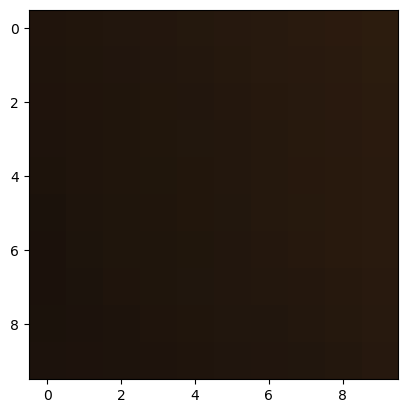

In [257]:
plt.imshow(cv2.cvtColor(samples[0], cv2.COLOR_BGR2RGB))

In [258]:
'''patches_2 = list(extract_patches_2d(roi_2, (50, 50)))
roi_2_patches = [p for p in patches_2 if np.all(p)]
print(len(roi_2_patches))
samples_2_idx = np.random.choice(np.arange(len(roi_2_patches)), 500, replace=False)

#samples += [roi_2_patches[i] for i in samples_2_idx]''';

In [259]:
'''plt.imshow(cv2.cvtColor(samples[-1], cv2.COLOR_BGR2RGB))''';

In [260]:
'''def adjust_contrast(s, alpha=.5, beta=10):

    new_image = np.zeros(s.shape, s.dtype)

    for y in range(s.shape[0]):
        for x in range(s.shape[1]):
            for c in range(s.shape[2]):
                new_image[y,x,c] = np.clip(alpha*s[y,x,c] + beta, 0, 255)
    return new_image''';

In [261]:
'''plt.imshow(cv2.cvtColor(adjust_contrast(samples[0]), cv2.COLOR_BGR2RGB))''';

In [262]:
'''samples = samples + [adjust_contrast(s) for s in samples]''';

In [263]:
def get_mean_and_covariance_matrix(samples, colour_space_fun, channel_num):
    
    covariance_tot = np.zeros((channel_num, channel_num), dtype='float32')
    mean_tot = np.zeros((channel_num,), dtype='float32')

    # CHANGE THE COLOR SPACE OF cvtColor TO THE DEFINED ONE

    for s in samples:
        # s_ab = cv2.cvtColor(s, cv2.COLOR_BGR2LAB)[:, :, channels]
        s_colour_space = colour_space_fun(s)

        s_colour_space = s_colour_space.reshape(-1, channel_num)
        cov, mean = cv2.calcCovarMatrix(s_colour_space, None, cv2.COVAR_NORMAL + cv2.COVAR_ROWS + cv2.COVAR_SCALE)
        covariance_tot = np.add(covariance_tot, cov)
        mean_tot = np.add(mean_tot, mean)

    mean = mean_tot / len(samples)
    print(covariance_tot)
    print(mean)
    covariance = covariance_tot / len(samples)
    return mean, covariance

In [264]:
# inv_covariance_matrix = np.linalg.inv(covariance_tot)

In [265]:
def get_mahalanobis_distance_img(img, colour_space_fun):
    img = colour_space_fun(img)
    channel_num = img.shape[2]
    # TODO ASSERT
    ##    assert channel_num > 1 , \
    ##    'At least two channels need to be provided.'
    
    mean, covariance = get_mean_and_covariance_matrix(samples, colour_space_fun, channel_num)
    inv_covariance_matrix = np.linalg.inv(covariance)
    
    #print(img.shape)

    img_flattened = img.reshape(-1, channel_num)
    img_flattened = img_flattened.astype(np.float64)
    print(img_flattened[0])
    print(mean)
    
    #img_res = [sc.spatial.distance.cdist(np.array([i]), mean, 'mahalanobis', VI=inv_covariance_matrix) for i in img_flattened]
    
    img_res = [
        cv2.Mahalanobis(i, mean[0], inv_covariance_matrix)  #if i[0] != 0 and i[1] != 0 else 200  
        for i in img_flattened
    ]
    
    img_res = np.array(img_res)
    #print(img_res.shape)
    img_res = img_res.reshape((img.shape[0], img.shape[1], 1));
    
    return img_res

In [266]:
def plot_tresholded_image(img, img_distance, treshold):
    img_tresh = np.copy(img_res)

    img_tresh[img_tresh > treshold] = 0

    green_mask = cv2.cvtColor(img_tresh.astype(np.uint8), cv2.COLOR_GRAY2BGR)
    # Force the bits of every channel except the green at 0
    green_mask[:,:,::2] = 0
    green_mask[green_mask != 0] = 255
    highlighted_roi = cv2.addWeighted(green_mask, 1, img, 1, 0)
    plt.imshow(cv2.cvtColor(highlighted_roi, cv2.COLOR_BGR2RGB))
    plt.show()

[[ 721.60302324  141.11959146]
 [ 141.11959146 2045.88101712]]
[[133.90202177 147.05841667]]
[128. 128.]
[[133.90202177 147.05841667]]


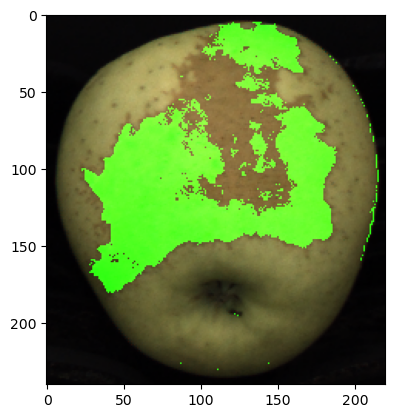

[[ 721.60302324  141.11959146]
 [ 141.11959146 2045.88101712]]
[[133.90202177 147.05841667]]
[128. 128.]
[[133.90202177 147.05841667]]


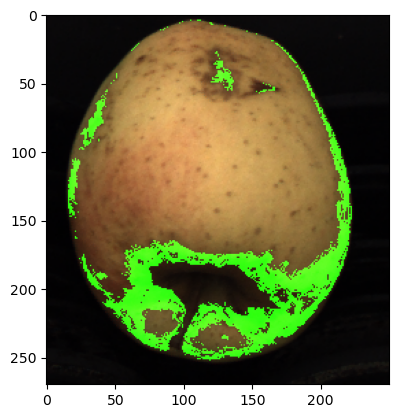

In [267]:
colour_space_fun = lambda img : cv2.cvtColor(img, cv2.COLOR_BGR2LAB)[:,:,colour_space_significant_channels_dict['LAB']]
img_res = get_mahalanobis_distance_img(masked_filtered_imgs[1], colour_space_fun) 
plot_tresholded_image(colour_imgs[1], img_res, 6)
img_res = get_mahalanobis_distance_img(masked_filtered_imgs[0], colour_space_fun) 
plot_tresholded_image(colour_imgs[0], img_res, 4)

[[ 791.47894586  768.27272441]
 [ 768.27272441 2182.80110716]]
[[107.40175442 154.14019626]]
[ 96. 136.]
[[107.40175442 154.14019626]]


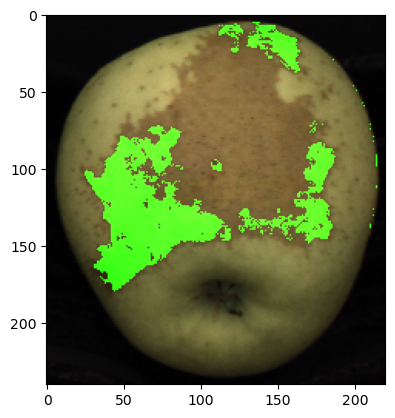

[[ 791.47894586  768.27272441]
 [ 768.27272441 2182.80110716]]
[[107.40175442 154.14019626]]
[ 96. 136.]
[[107.40175442 154.14019626]]


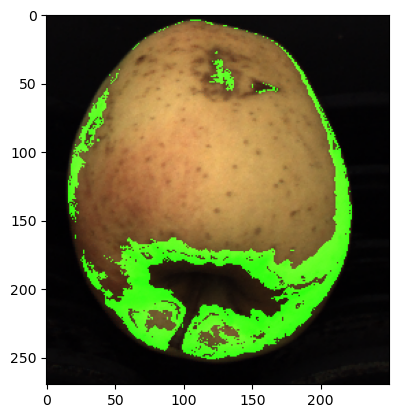

In [268]:
colour_space_fun = lambda img : cv2.cvtColor(img, cv2.COLOR_BGR2Luv)[:,:,colour_space_significant_channels_dict['LUV']]
img_res = get_mahalanobis_distance_img(masked_filtered_imgs[1], colour_space_fun) 
plot_tresholded_image(colour_imgs[1], img_res, 5)
img_res = get_mahalanobis_distance_img(masked_filtered_imgs[0], colour_space_fun) 
plot_tresholded_image(colour_imgs[0], img_res, 5)

[[ 835.45631991 -763.08550075]
 [-763.08550075 1669.99015914]]
[[141.1944915  110.91284252]]
[128. 128.]
[[141.1944915  110.91284252]]


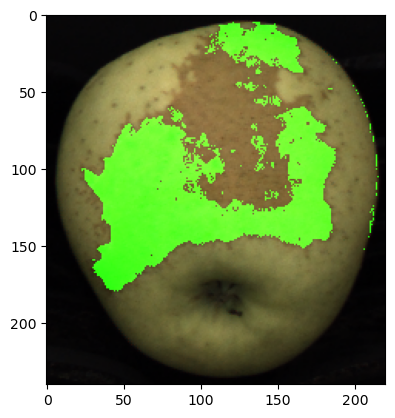

[[ 835.45631991 -763.08550075]
 [-763.08550075 1669.99015914]]
[[141.1944915  110.91284252]]
[128. 128.]
[[141.1944915  110.91284252]]


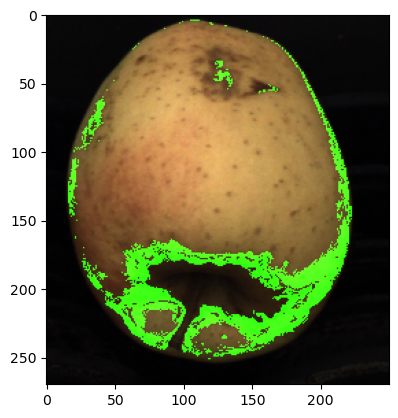

In [269]:
colour_space_fun = lambda img : cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)[:,:,colour_space_significant_channels_dict['YCrCb']]
img_res = get_mahalanobis_distance_img(masked_filtered_imgs[1], colour_space_fun) 
plot_tresholded_image(colour_imgs[1], img_res, 6)
img_res = get_mahalanobis_distance_img(masked_filtered_imgs[0], colour_space_fun) 
plot_tresholded_image(colour_imgs[0], img_res, 4)

[[ 1785.54565473  1618.9371733 ]
 [ 1618.9371733  19774.34651129]]
[[ 22.04851497 147.57929524]]
[0. 0.]
[[ 22.04851497 147.57929524]]


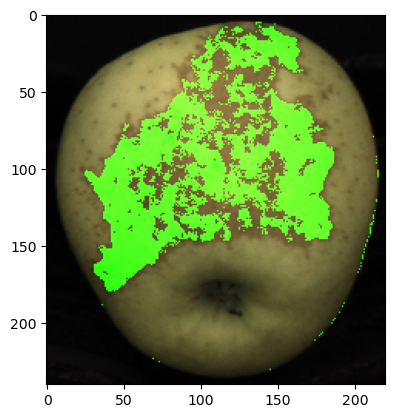

[[ 1785.54565473  1618.9371733 ]
 [ 1618.9371733  19774.34651129]]
[[ 22.04851497 147.57929524]]
[0. 0.]
[[ 22.04851497 147.57929524]]


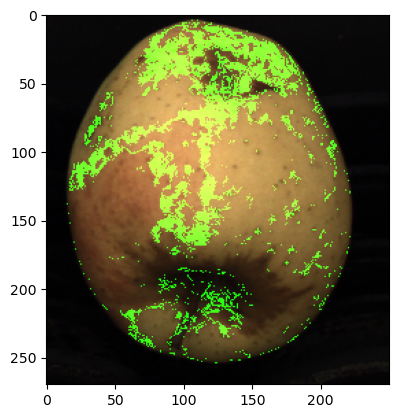

In [270]:
colour_space_fun = lambda img : cv2.cvtColor(img, cv2.COLOR_BGR2HSV_FULL)[:,:,colour_space_significant_channels_dict['HSV']]
img_res = get_mahalanobis_distance_img(masked_filtered_imgs[1], colour_space_fun) 
plot_tresholded_image(colour_imgs[1], img_res,4)
img_res = get_mahalanobis_distance_img(masked_filtered_imgs[0], colour_space_fun) 
plot_tresholded_image(colour_imgs[0], img_res,2)

[[ 1773.70312674  1479.43652782]
 [ 1479.43652782 18851.37943861]]
[[ 21.69984048 103.8909534 ]]
[0. 0.]
[[ 21.69984048 103.8909534 ]]


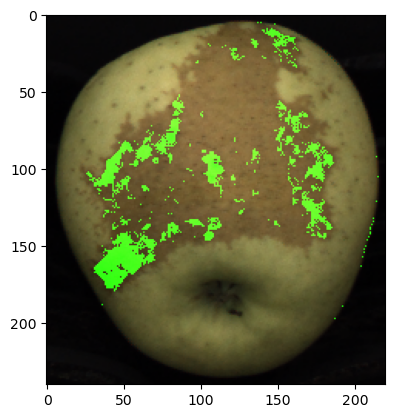

[[ 1773.70312674  1479.43652782]
 [ 1479.43652782 18851.37943861]]
[[ 21.69984048 103.8909534 ]]
[0. 0.]
[[ 21.69984048 103.8909534 ]]


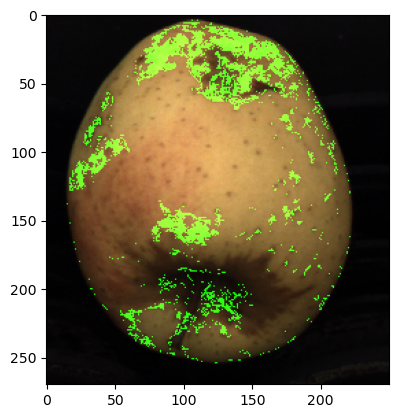

In [271]:
colour_space_fun = lambda img : cv2.cvtColor(img, cv2.COLOR_BGR2HLS_FULL)[:,:,colour_space_significant_channels_dict['HLS']]
img_res = get_mahalanobis_distance_img(masked_filtered_imgs[1], colour_space_fun) 
plot_tresholded_image(colour_imgs[1], img_res,3)
img_res = get_mahalanobis_distance_img(masked_filtered_imgs[0], colour_space_fun) 
plot_tresholded_image(colour_imgs[0], img_res,2)

[[ 1311.95603086 -1618.84060267  -828.85661499  -824.8522045 ]
 [-1618.84060267  2182.80110716  1074.39482836  1071.88499421]
 [ -828.85661499  1074.39482836  1785.54565473  1725.17775414]
 [ -824.8522045   1071.88499421  1725.17775414  1773.70312674]]
[[113.11214456 154.14019626  22.04851497  21.69984048]]
[128. 136.   0.   0.]
[[113.11214456 154.14019626  22.04851497  21.69984048]]


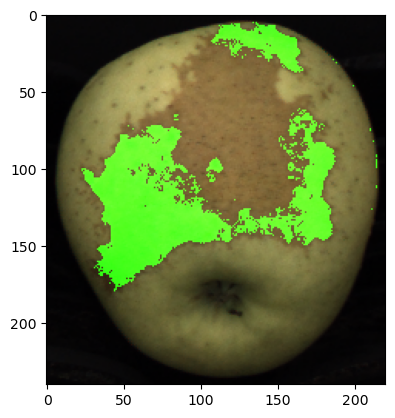

[[ 1311.95603086 -1618.84060267  -828.85661499  -824.8522045 ]
 [-1618.84060267  2182.80110716  1074.39482836  1071.88499421]
 [ -828.85661499  1074.39482836  1785.54565473  1725.17775414]
 [ -824.8522045   1071.88499421  1725.17775414  1773.70312674]]
[[113.11214456 154.14019626  22.04851497  21.69984048]]
[128. 136.   0.   0.]
[[113.11214456 154.14019626  22.04851497  21.69984048]]


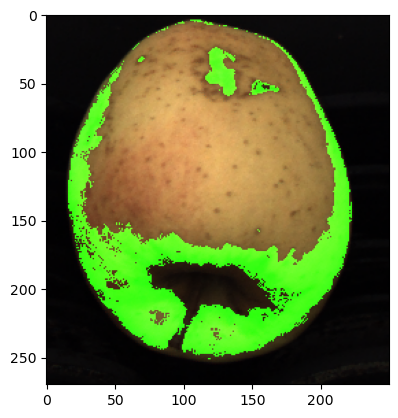

In [272]:
def colour_space_fun(img):
    yuv_1 =  cv2.cvtColor(img, cv2.COLOR_BGR2YUV)[:,:,1]
    luv_2 = cv2.cvtColor(img, cv2.COLOR_BGR2Luv)[:,:,2]
    hsv_0 =  cv2.cvtColor(img, cv2.COLOR_BGR2HSV_FULL)[:,:,0]
    hls_0 = cv2.cvtColor(img, cv2.COLOR_BGR2HLS_FULL)[:,:,0]

    yuv_1 = np.expand_dims(yuv_1, axis=2)
    luv_2 = np.expand_dims(luv_2, axis=2)
    hsv_0 = np.expand_dims(hsv_0, axis=2)
    hls_0 = np.expand_dims(hls_0, axis=2)

    return np.concatenate((yuv_1, luv_2, hsv_0, hls_0), axis = -1)

img_res = get_mahalanobis_distance_img(masked_filtered_imgs[1], colour_space_fun) 
plot_tresholded_image(colour_imgs[1], img_res, 6)
img_res = get_mahalanobis_distance_img(masked_filtered_imgs[0], colour_space_fun) 
plot_tresholded_image(colour_imgs[0], img_res, 6)